In [1]:
# 导入必要的库
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datetime import datetime, timedelta


# 配置
DATA_DIR = r"data\Air pollution data\FI"
URLS_CSV = r"data\Air pollution data\FI\ParquetFilesUrlse1a.csv"
METADATA_DIR = r"data\Air pollution data\metadata\AirQualityStation.csv"

# 设置固定日期范围
START_DATE = "2020-10-01"
END_DATE = "2025-09-30"
# 预测开始日期
PREDICTION_START_DATE = "2025-10-01"

# 定义要预测的污染物
POLLUTANTS = {
    6001: "PM2.5",
    5: "PM10",
    1: "SO2",
    7: "O3"
}

print(f'Fetching data from {START_DATE} to {END_DATE}')
print(f'Prediction will start from {PREDICTION_START_DATE} for one year')
print(f'Pollutants to predict: {POLLUTANTS}')

Fetching data from 2020-10-01 to 2025-09-30
Prediction will start from 2025-10-01 for one year
Pollutants to predict: {6001: 'PM2.5', 5: 'PM10', 1: 'SO2', 7: 'O3'}


In [2]:
# 下载parquet文件的函数
def download_parquet_files(urls_csv, data_dir):
    # 从CSV文件读取URLs
    urls = pd.read_csv(urls_csv)["ParquetFileUrl"]
    # 下载每个文件
    for url in urls:
        file_name = url.split('/')[-1]
        file_path = os.path.join(data_dir, file_name)
        # 只在文件不存在时下载
        if not os.path.exists(file_path):
            print(f'Downloading {file_name}...')
            try:
                response = requests.get(url)
                response.raise_for_status()
                with open(file_path, 'wb') as f:
                    f.write(response.content)
            except Exception as e:
                print(f'Error downloading {file_name}: {e}')
        else:
            print(f'{file_name} already exists, skipping download.')


In [3]:
# 加载和预处理空气污染数据的函数
def load_air_pollution_data(data_dir, start_date, end_date, metadata_dir=None):
    # 定义要读取的列
    columns_air = ["Samplingpoint", "Pollutant", "Start", "Value", "Unit", "Validity"]
    
    # 初始化空DataFrame
    df_air = pd.DataFrame()
    
    # 遍历目录并读取所有parquet文件
    for root, _, files in os.walk(data_dir):
        for filename in files:
            if filename.endswith('.parquet'):
                file_path = os.path.join(root, filename)
                try:
                    # 读取parquet文件
                    data = pd.read_parquet(file_path, columns=columns_air)
                    # 合并到主DataFrame
                    df_air = pd.concat([df_air, data])
                except Exception as e:
                    print(f'Error reading {filename}: {e}')
    
    # 数据清洗和预处理
    if not df_air.empty:
        # 将Start列转换为datetime类型
        df_air['Start'] = pd.to_datetime(df_air['Start'])
        
        # 按日期范围过滤数据
        df_air = df_air[(df_air['Start'] >= start_date) & (df_air['Start'] <= end_date)]
        
        # 只保留有效数据
        df_air = df_air[df_air['Validity'] == 1]
        
        # 移除Validity列，因为不再需要
        df_air = df_air.drop(['Validity'], axis=1)
        
        # 从Samplingpoint中移除国家代码前缀
        if 'Samplingpoint' in df_air.columns:
            df_air['Samplingpoint'] = df_air['Samplingpoint'].str[3:]
        
        # 将Value转换为float并处理负值
        df_air['Value'] = pd.to_numeric(df_air['Value'], errors='coerce')
        df_air['Value'] = df_air['Value'].where(lambda x: x > 0, np.nan)
        
        # 前向填充缺失值
        df_air = df_air.ffill()
        
        # 删除任何剩余的NaN值
        df_air = df_air.dropna()
        
        # 加载metadata并合并
        if metadata_dir and os.path.exists(metadata_dir):
            columns_metadata = ["Country", "Timezone", "Sampling Point Id", "Air Pollutant", "Longitude", "Latitude", "Air Quality Station Name"]
            df_metadata = pd.read_csv(metadata_dir, usecols=columns_metadata)
            df_metadata = df_metadata.drop_duplicates()  # 去除重复项
            
            # 合并数据
            df_merged = pd.merge(df_air, df_metadata, left_on="Samplingpoint", right_on="Sampling Point Id", how="left")
            
            # 处理缺失的站点名称
            df_merged['Air Quality Station Name'] = df_merged['Air Quality Station Name'].fillna(df_merged['Samplingpoint'])
            
            return df_merged
    
    return df_air

In [4]:

# 执行数据获取
print('Downloading parquet files...')
download_parquet_files(URLS_CSV, DATA_DIR)

print('\nLoading and preprocessing air pollution data...')
df_air = load_air_pollution_data(DATA_DIR, START_DATE, END_DATE, METADATA_DIR)

print(f'\nLoaded {len(df_air)} records')
if not df_air.empty:
    print('\nSample data:')
    print(df_air.head())
    print('\nData summary:')
    print(df_air.describe())
    
    # 获取所有唯一站点
    if 'Air Quality Station Name' in df_air.columns:
        stations = df_air['Air Quality Station Name'].unique()
        print(f'\nFound {len(stations)} unique air quality stations:')
        print(stations)
    else:
        stations = df_air['Samplingpoint'].unique()
        print(f'\nFound {len(stations)} unique sampling stations:')
        print(stations)

# 为GRU准备多污染物时间序列数据的函数
def prepare_multi_pollutant_data(df, pollutant_ids, station_name, sequence_length=24):
    """准备指定站点的多污染物时间序列数据"""
    # 按站点名称过滤数据
    if 'Air Quality Station Name' in df.columns:
        df_station = df[df['Air Quality Station Name'] == station_name].copy()
    else:
        # 如果没有站点名称，回退到使用采样点ID
        df_station = df[df['Samplingpoint'] == station_name].copy()
    
    # 确保数据按时间排序
    df_station = df_station.sort_values('Start')
    
    # 获取唯一的日期时间点
    timestamps = df_station['Start'].unique()
    timestamps = np.sort(timestamps)
    
    # 创建一个时间点索引的数据框，用于合并不同污染物的数据
    multi_pollutant_df = pd.DataFrame({'Start': timestamps})
    
    # 为每个污染物创建一列
    valid_pollutant_ids = []
    for pollutant_id in pollutant_ids:
        pollutant_data = df_station[df_station['Pollutant'] == pollutant_id][['Start', 'Value']]
        pollutant_data = pollutant_data.rename(columns={'Value': f'Value_{pollutant_id}'})
        multi_pollutant_df = pd.merge(multi_pollutant_df, pollutant_data, on='Start', how='left')
        
        # 检查该污染物是否有数据
        if not pollutant_data.empty:
            valid_pollutant_ids.append(pollutant_id)
    
    # 如果没有有效污染物，返回空数据
    if not valid_pollutant_ids:
        print(f'No valid pollutant data for station {station_name}')
        return np.array([]), np.array([]), {}, []
    
    # 填充缺失值
    multi_pollutant_df = multi_pollutant_df.ffill().bfill()
    multi_pollutant_df = multi_pollutant_df.dropna()
    
    # 如果数据框为空，返回空数据
    if multi_pollutant_df.empty:
        print(f'No valid data after filling and cleaning for station {station_name}')
        return np.array([]), np.array([]), {}, []
    
    # 准备数据用于时间序列预测
    X, y, dates = [], [], []
    feature_cols = [f'Value_{pid}' for pid in valid_pollutant_ids]
    num_features = len(valid_pollutant_ids)
    
    # 为每个特征创建单独的缩放器
    scalers = {}
    
    # 对每个污染物进行归一化
    scaled_values = np.zeros((len(multi_pollutant_df), num_features))
    for i, pid in enumerate(valid_pollutant_ids):
        values_col = multi_pollutant_df[f'Value_{pid}'].values.reshape(-1, 1)
        # 确保values_col不为空
        if len(values_col) > 0:
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_values[:, i] = scaler.fit_transform(values_col).flatten()
            scalers[pid] = scaler
    
    # 创建时间序列序列
    for i in range(len(scaled_values) - sequence_length):
        X.append(scaled_values[i:i+sequence_length])
        y.append(scaled_values[i+sequence_length])
        dates.append(multi_pollutant_df.iloc[i+sequence_length]['Start'])
    
    # 转换为numpy数组
    X = np.array(X)
    y = np.array(y)
    
    return X, y, scalers, dates


SPO-FI00027_00001_100.parquet already exists, skipping download.
SPO-FI00027_06001_100.parquet already exists, skipping download.
SPO-FI00074_00005_100.parquet already exists, skipping download.
SPO-FI00074_06001_100.parquet already exists, skipping download.
SPO-FI00080_00001_100.parquet already exists, skipping download.
SPO-FI00080_00005_100.parquet already exists, skipping download.
SPO-FI00179_00001_100.parquet already exists, skipping download.
SPO-FI00179_00005_100.parquet already exists, skipping download.
SPO-FI00184_00001_100.parquet already exists, skipping download.
SPO-FI00184_00005_100.parquet already exists, skipping download.
SPO-FI00186_00005_100.parquet already exists, skipping download.
SPO-FI00186_00010_100.parquet already exists, skipping download.
SPO-FI00206_00001_100.parquet already exists, skipping download.
SPO-FI00206_00005_100.parquet already exists, skipping download.
SPO-FI00208_00001_100.parquet already exists, skipping download.
SPO-FI00208_00005_101.par

In [10]:
# 自定义PyTorch数据集类
class MultiPollutantDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class CNNLSTMPollution(nn.Module):
    def __init__(self, input_size, output_size, seq_len=24):
        super(CNNLSTMPollution, self).__init__()
        # CNN部分提取局部特征
        self.conv1d = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # LSTM部分捕捉长期依赖
        self.lstm = nn.LSTM(32, 128, batch_first=True, num_layers=2, dropout=0.2)
        self.output_layer = nn.Linear(128, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = x.transpose(1, 2)  # (batch_size, input_dim, seq_len)
        x = self.conv1d(x)     # (batch_size, 32, seq_len)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 32)
        
        lstm_out, (h_n, c_n) = self.lstm(x)
        output = self.output_layer(lstm_out[:, -1, :])
        return output

In [11]:
# 训练函数
def train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001):
    # 设置设备（可用GPU时使用GPU，否则使用CPU）
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 训练历史
    train_losses = []
    test_losses = []
    
    # 训练循环
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # 前向传播
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        # 计算平均训练损失
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # 在测试集上评估
        model.eval()
        test_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)
        
        # 计算平均测试损失
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        
        # 打印进度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return model, train_losses, test_losses


In [12]:

# 评估模型并进行预测的函数
def evaluate_model(model, test_loader, scalers, pollutant_ids):
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    # 存储预测和实际值的字典
    all_predictions = {pid: [] for pid in pollutant_ids if pid in scalers}
    all_actuals = {pid: [] for pid in pollutant_ids if pid in scalers}
    
    # 在测试集上进行预测
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            
            # 转换为numpy
            predictions_np = predictions.cpu().numpy()
            y_batch_np = y_batch.numpy()
            
            # 对每个污染物进行反向转换
            for i, pid in enumerate(pollutant_ids):
                if pid not in scalers:
                    continue
                pred_col = predictions_np[:, i].reshape(-1, 1)
                actual_col = y_batch_np[:, i].reshape(-1, 1)
                
                pred_inv = scalers[pid].inverse_transform(pred_col).flatten()
                actual_inv = scalers[pid].inverse_transform(actual_col).flatten()
                
                all_predictions[pid].extend(pred_inv)
                all_actuals[pid].extend(actual_inv)
    
    # 计算每个污染物的评估指标
    metrics = {}
    for pid in pollutant_ids:
        if pid not in scalers or not all_predictions[pid]:
            continue
        mse = mean_squared_error(all_actuals[pid], all_predictions[pid])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(all_actuals[pid], all_predictions[pid])
        metrics[pid] = {'rmse': rmse, 'mae': mae}
        
        print(f'Pollutant {pid} ({POLLUTANTS[pid]}) Evaluation Metrics:')
        print(f'RMSE: {rmse:.4f}')
        print(f'MAE: {mae:.4f}')
    
    return all_predictions, all_actuals, metrics

In [13]:
def predict_future_cnn_lstm(model, last_sequence, scalers, pollutant_ids, prediction_days=30):
    """适用于CNN-LSTM模型的预测函数"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    current_sequence = torch.tensor(last_sequence, dtype=torch.float32).to(device)
    current_sequence = current_sequence.unsqueeze(0)  # (1, seq_len, features)
    
    future_predictions = []
    
    with torch.no_grad():
        for i in range(prediction_days * 24):
            # CNN-LSTM预测
            next_pred = model(current_sequence)
            
            # 添加到预测列表
            next_pred_np = next_pred.cpu().numpy()[0]
            future_predictions.append(next_pred_np)
            
            # 更新序列：移除最旧的时间步，添加新的预测
            new_sequence = torch.cat([
                current_sequence[:, 1:, :],  # 移除第一个时间步
                next_pred.unsqueeze(1)       # 添加新的预测作为最后一个时间步
            ], dim=1)
            current_sequence = new_sequence
    
    # 反归一化处理（与原来相同）
    future_predictions = np.array(future_predictions)
    inv_predictions = {}
    
    for i, pid in enumerate(pollutant_ids):
        if pid in scalers and i < future_predictions.shape[1]:
            pred_col = future_predictions[:, i].reshape(-1, 1)
            pred_col = np.clip(pred_col, 0, 1)
            inv_predictions[pid] = scalers[pid].inverse_transform(pred_col).flatten()
    
    return inv_predictions

Processing 63 air quality stations...


Processing station: Nokela
No valid data after filling and cleaning for station Nokela
No valid data for station Nokela, skipping...


Processing station: Rautionkylä
No valid data after filling and cleaning for station Rautionkylä
No valid data for station Rautionkylä, skipping...


Processing station: Pirkkala
No valid data after filling and cleaning for station Pirkkala
No valid data for station Pirkkala, skipping...


Processing station: Kaleva
Prepared 6506 samples for station Kaleva
Train samples: 5204, Test samples: 1302
Training model for station Kaleva...
Epoch [10/50], Train Loss: 0.0018, Test Loss: 0.0010
Epoch [20/50], Train Loss: 0.0016, Test Loss: 0.0012
Epoch [30/50], Train Loss: 0.0016, Test Loss: 0.0014
Epoch [40/50], Train Loss: 0.0015, Test Loss: 0.0011
Epoch [50/50], Train Loss: 0.0014, Test Loss: 0.0010


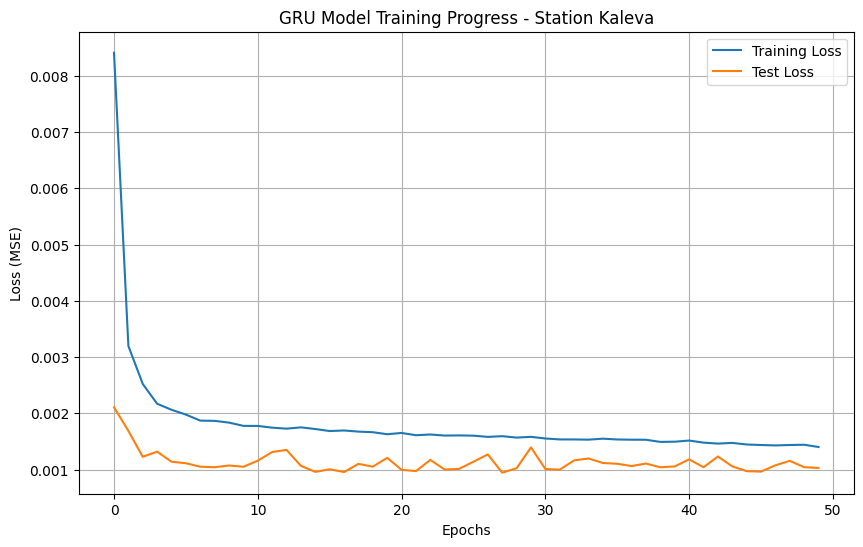

Evaluating model for station Kaleva...
Pollutant 6001 (PM2.5) Evaluation Metrics:
RMSE: 0.9679
MAE: 0.5703
Pollutant 5 (PM10) Evaluation Metrics:
RMSE: 2.0518
MAE: 1.4984
Pollutant 1 (SO2) Evaluation Metrics:
RMSE: 6.1534
MAE: 2.6566
Pollutant 7 (O3) Evaluation Metrics:
RMSE: 4.7202
MAE: 3.4656


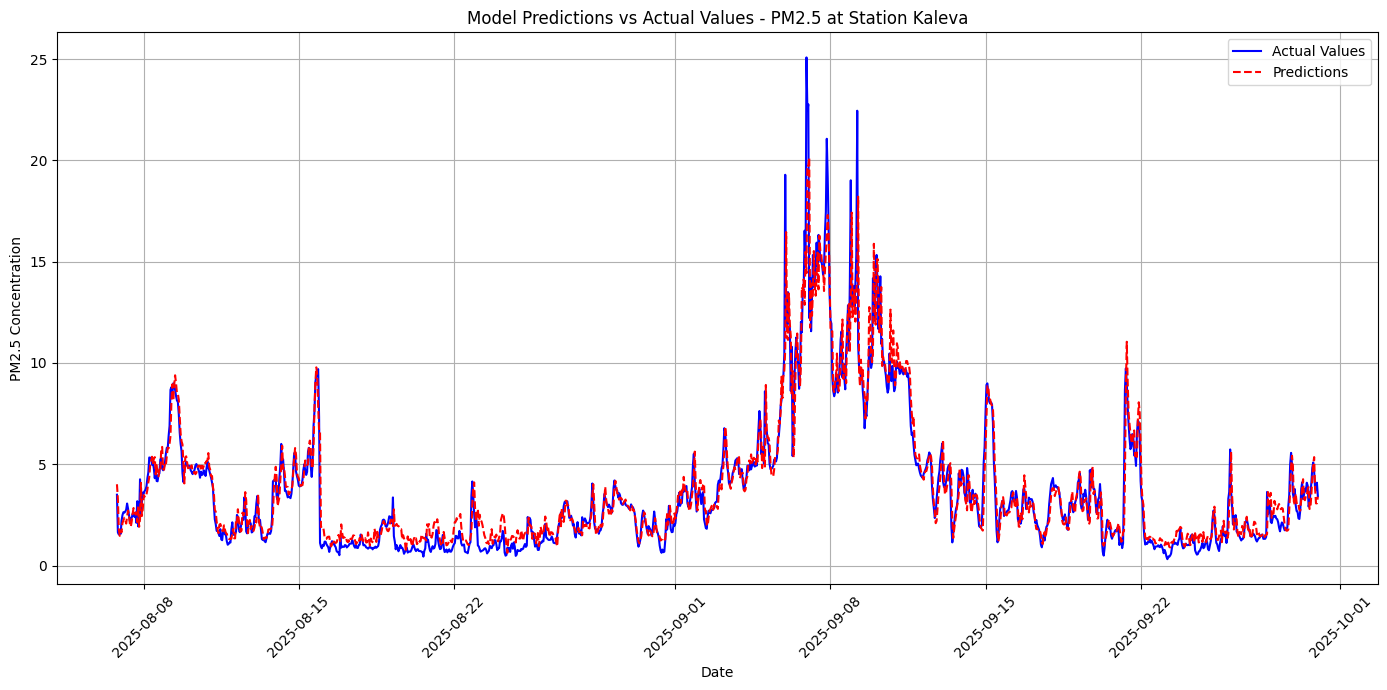

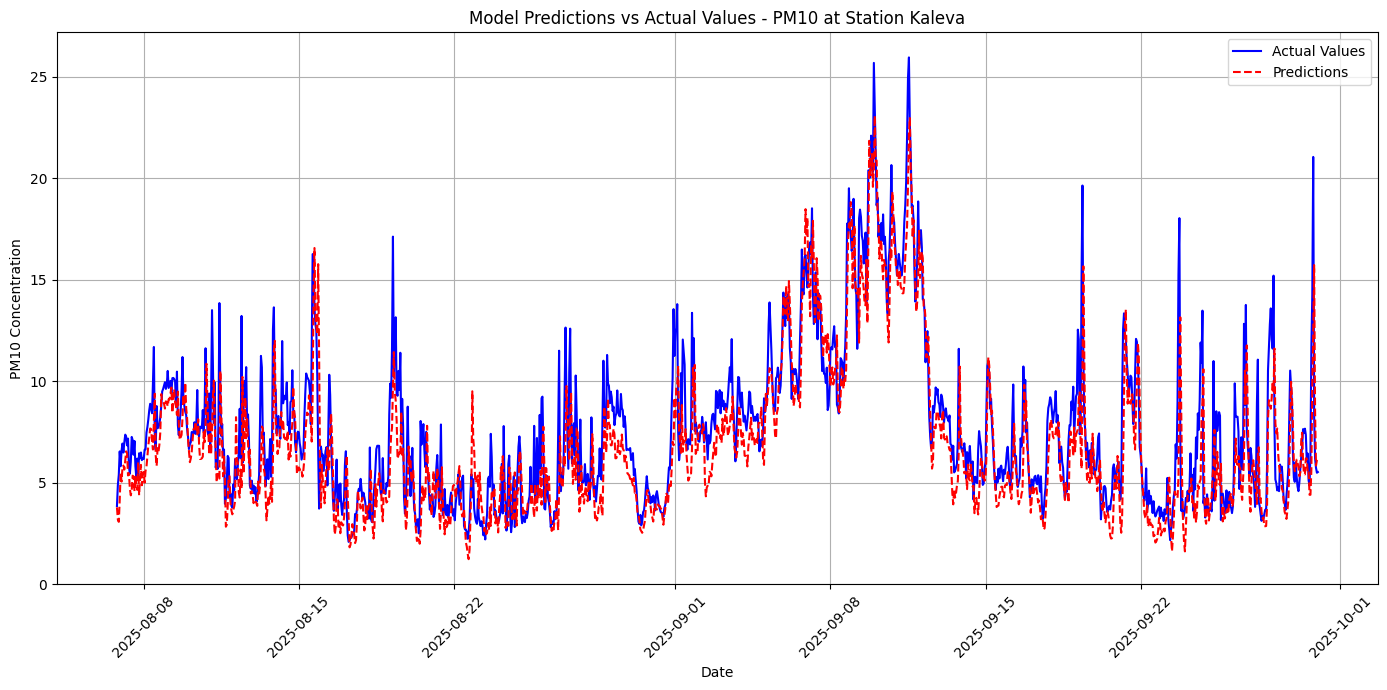

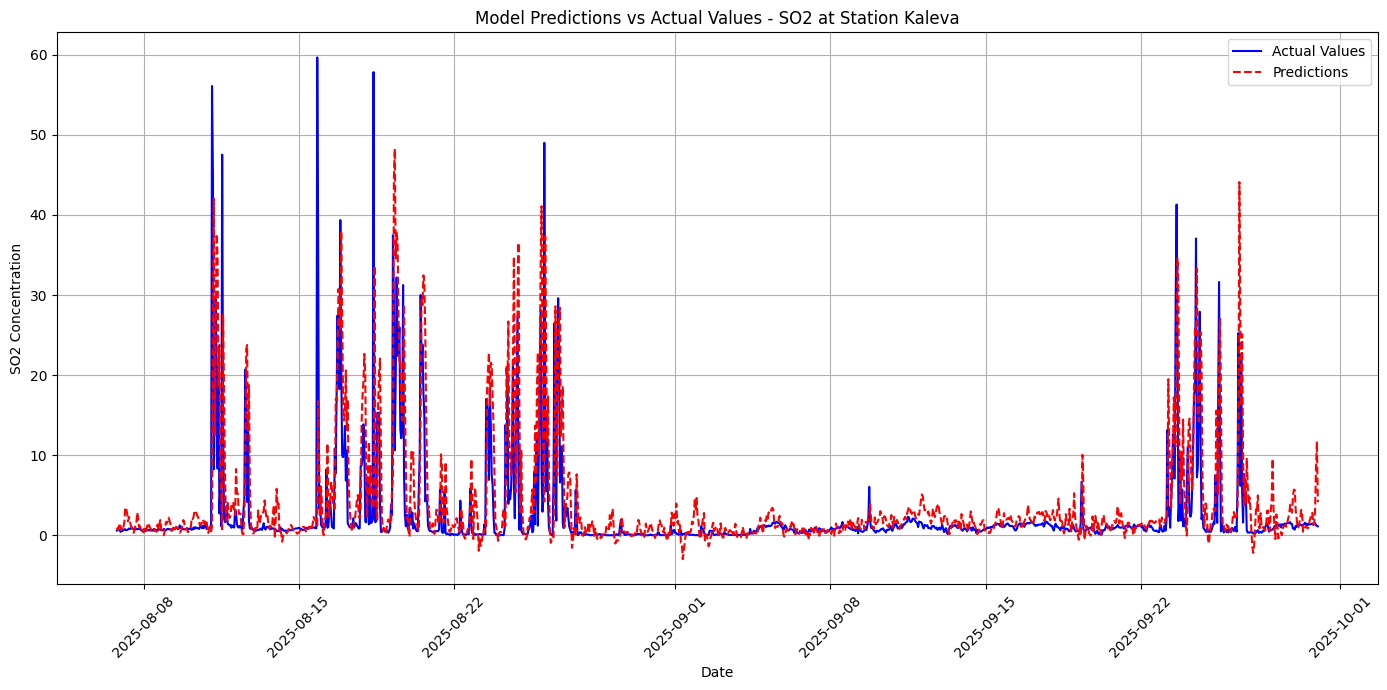

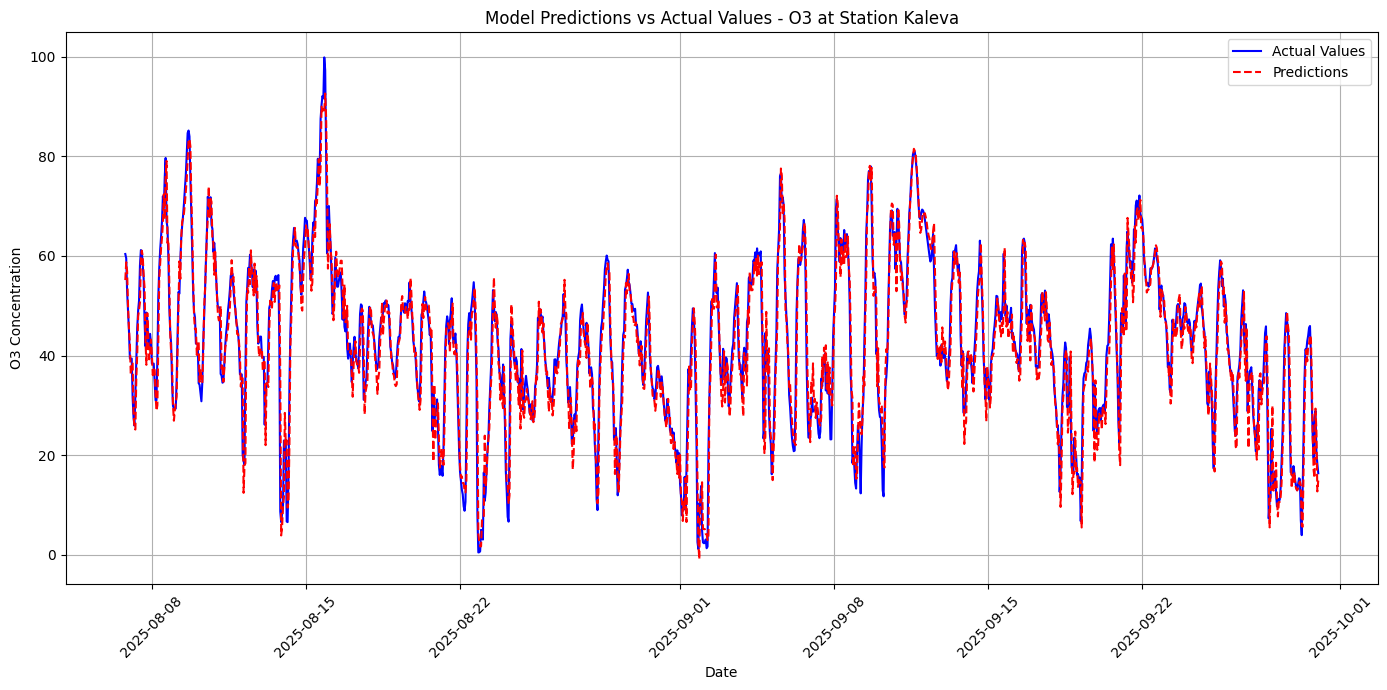

Making future predictions for station Kaleva...


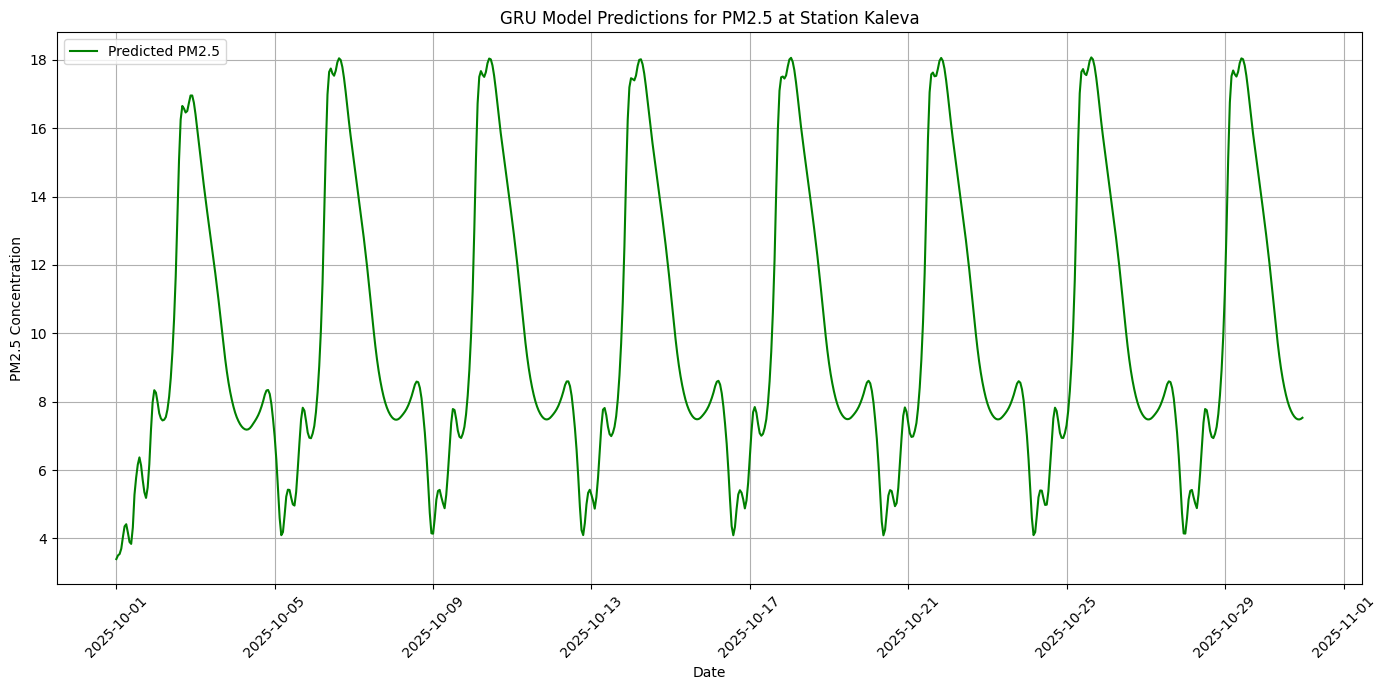

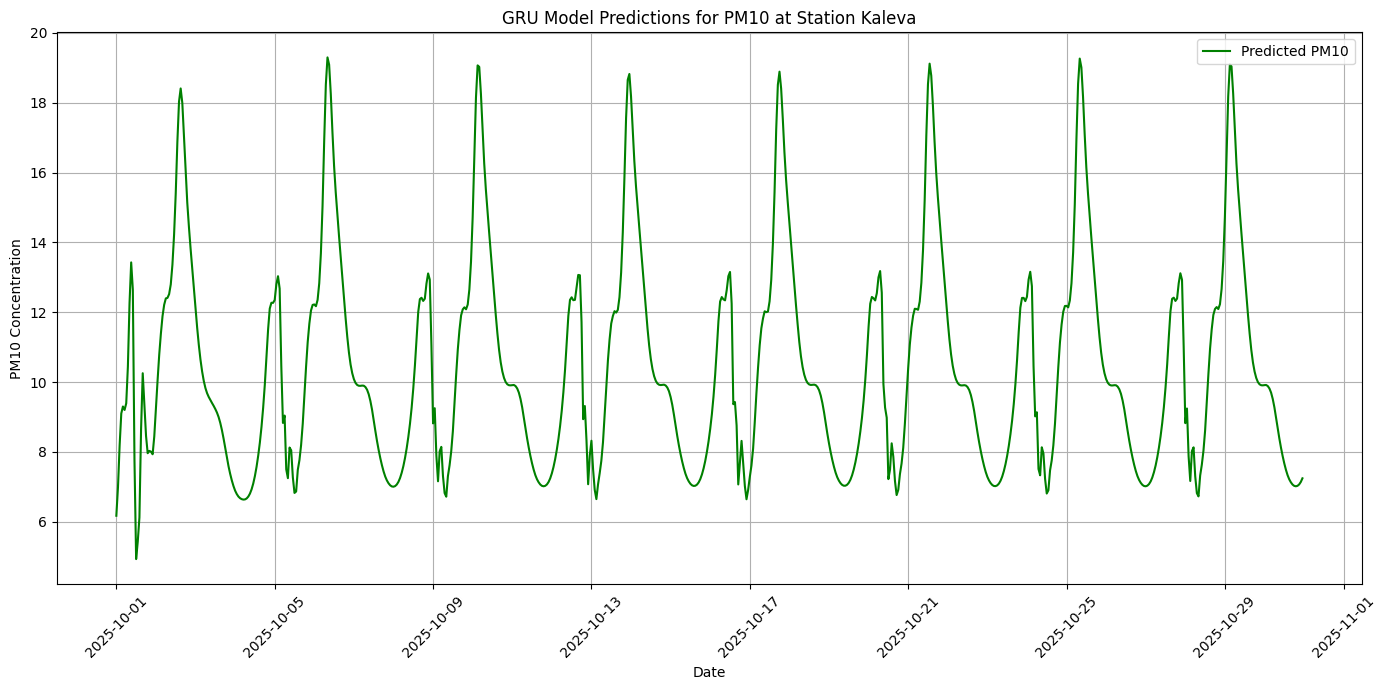

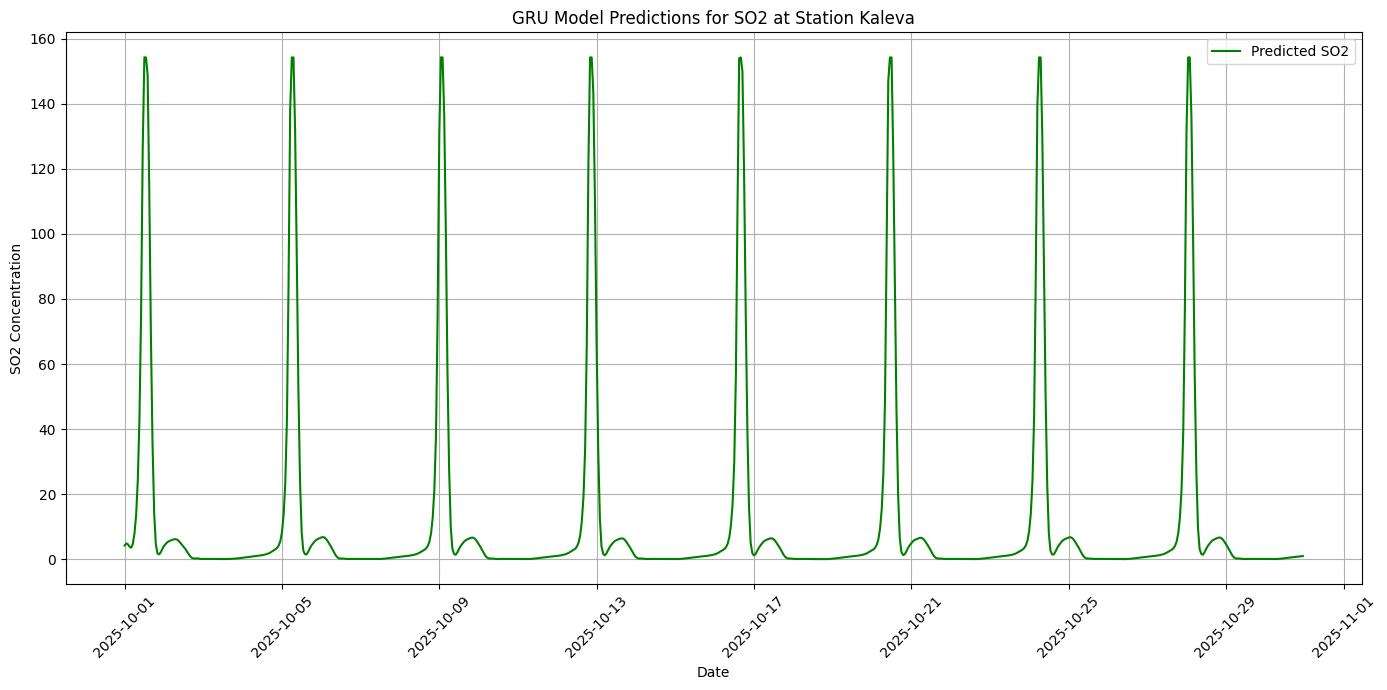

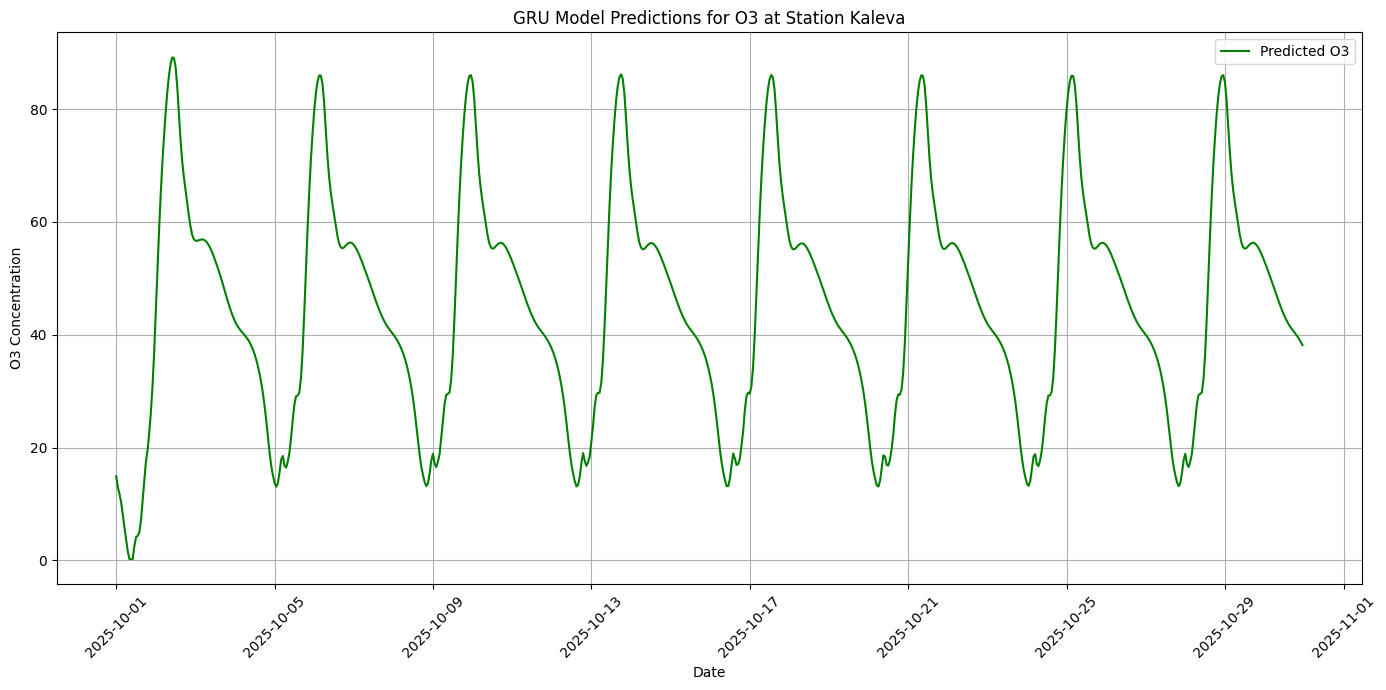

Predictions for station Kaleva saved to predictions_station_Kaleva.csv

Summary of Predictions for Station Kaleva:
PM2.5:
  Minimum predicted level: 3.40
  Maximum predicted level: 18.07
  Average predicted level: 9.92
  Standard deviation: 4.14
PM10:
  Minimum predicted level: 4.93
  Maximum predicted level: 19.29
  Average predicted level: 10.44
  Standard deviation: 3.05
SO2:
  Minimum predicted level: 0.00
  Maximum predicted level: 154.30
  Average predicted level: 11.85
  Standard deviation: 32.53
O3:
  Minimum predicted level: 0.23
  Maximum predicted level: 89.17
  Average predicted level: 45.01
  Standard deviation: 20.00


Processing station: Luukki
Prepared 6495 samples for station Luukki
Train samples: 5196, Test samples: 1299
Training model for station Luukki...
Epoch [10/50], Train Loss: 0.0009, Test Loss: 0.0004
Epoch [20/50], Train Loss: 0.0007, Test Loss: 0.0004
Epoch [30/50], Train Loss: 0.0007, Test Loss: 0.0004
Epoch [40/50], Train Loss: 0.0007, Test Loss: 0.0003
Ep

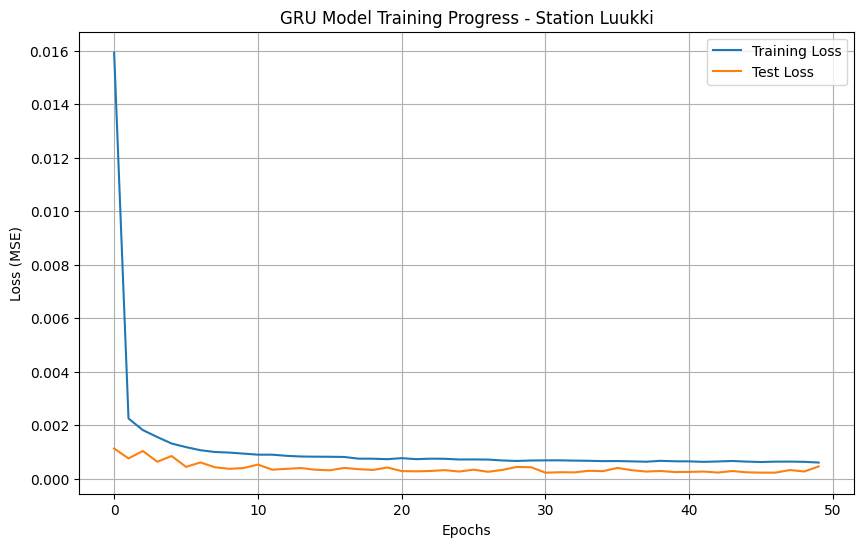

Evaluating model for station Luukki...
Pollutant 6001 (PM2.5) Evaluation Metrics:
RMSE: 1.1003
MAE: 0.8939
Pollutant 5 (PM10) Evaluation Metrics:
RMSE: 1.7026
MAE: 1.3011
Pollutant 1 (SO2) Evaluation Metrics:
RMSE: 0.2868
MAE: 0.2230
Pollutant 7 (O3) Evaluation Metrics:
RMSE: 1.0860
MAE: 0.9925


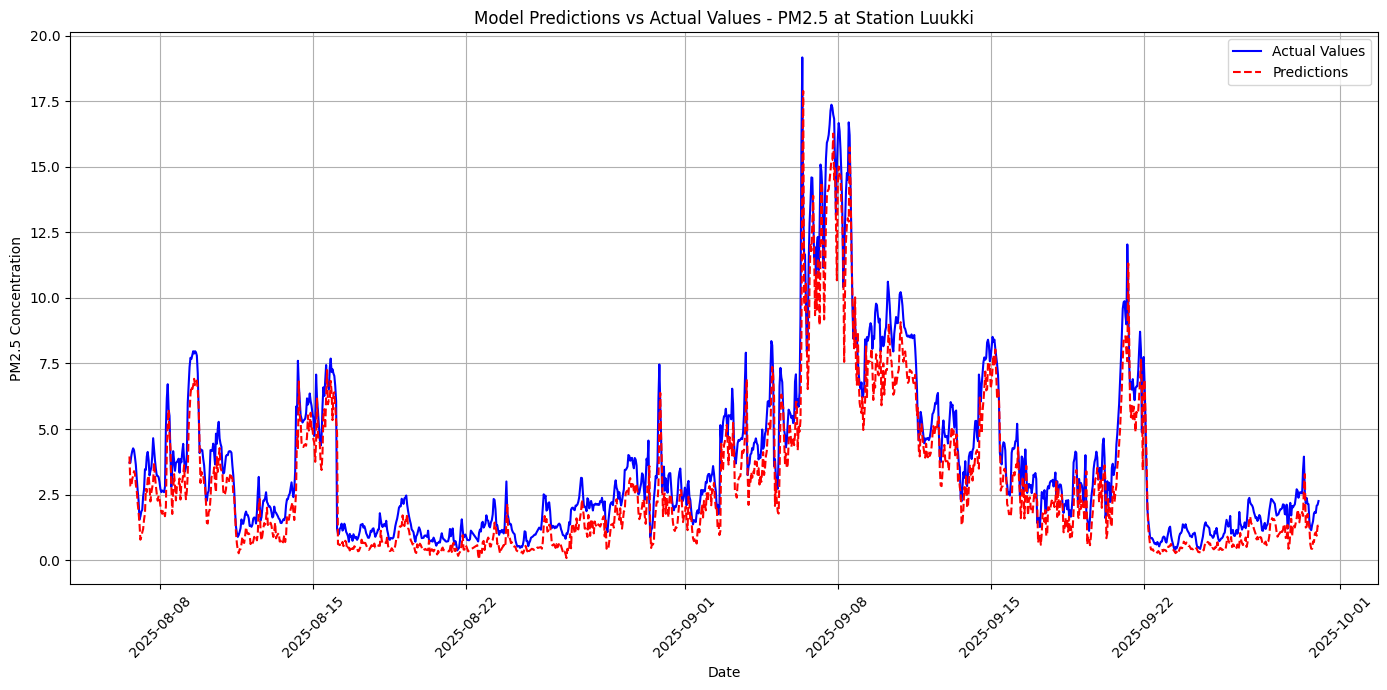

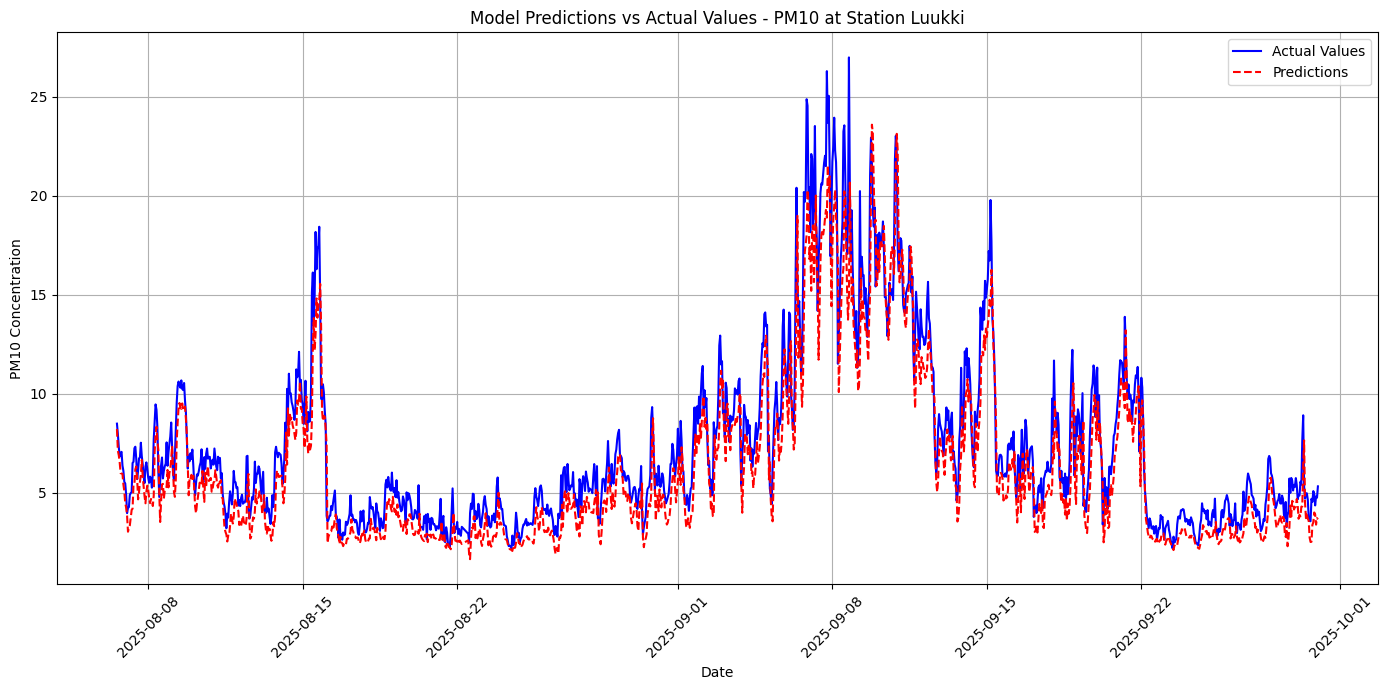

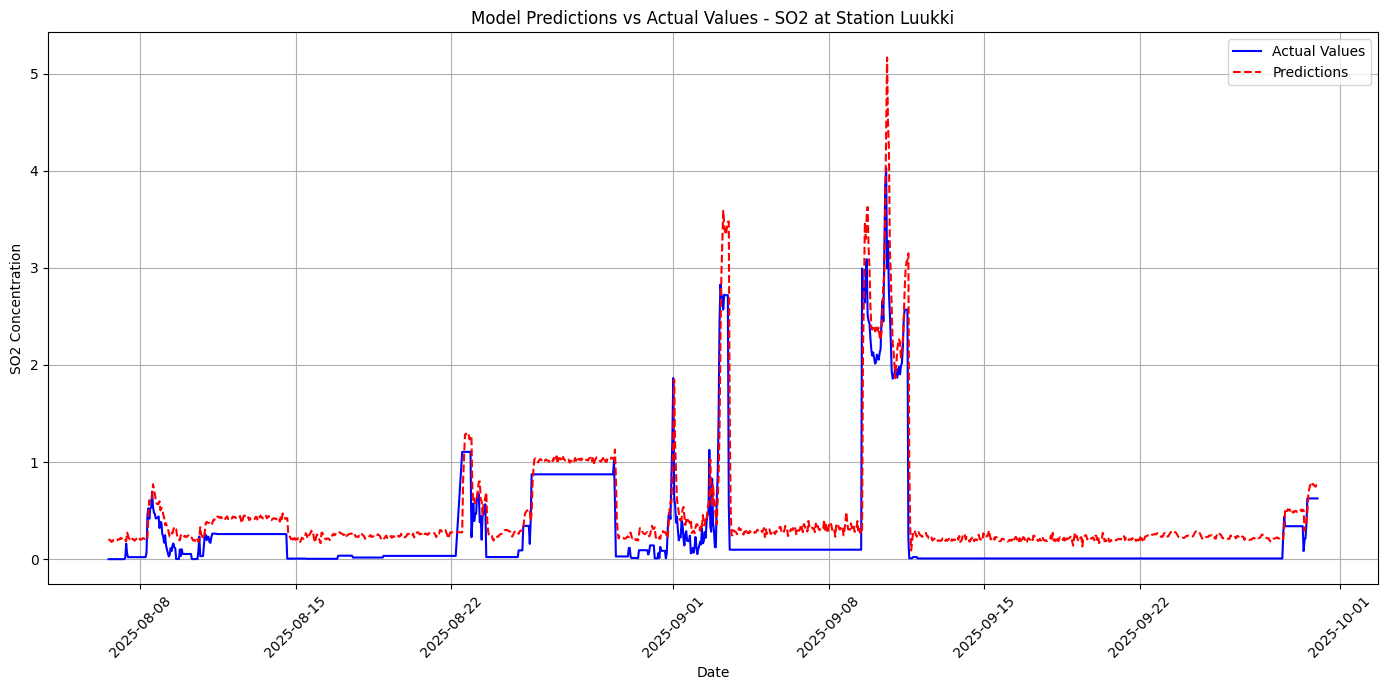

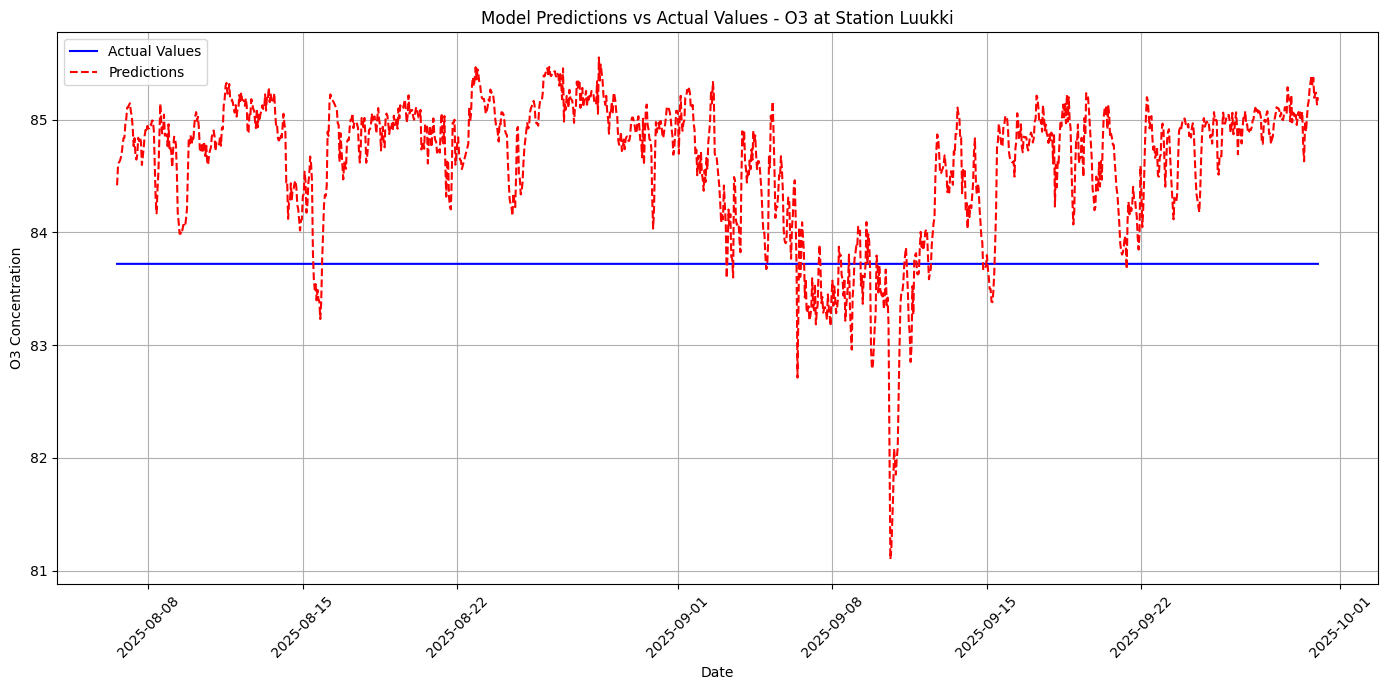

Making future predictions for station Luukki...


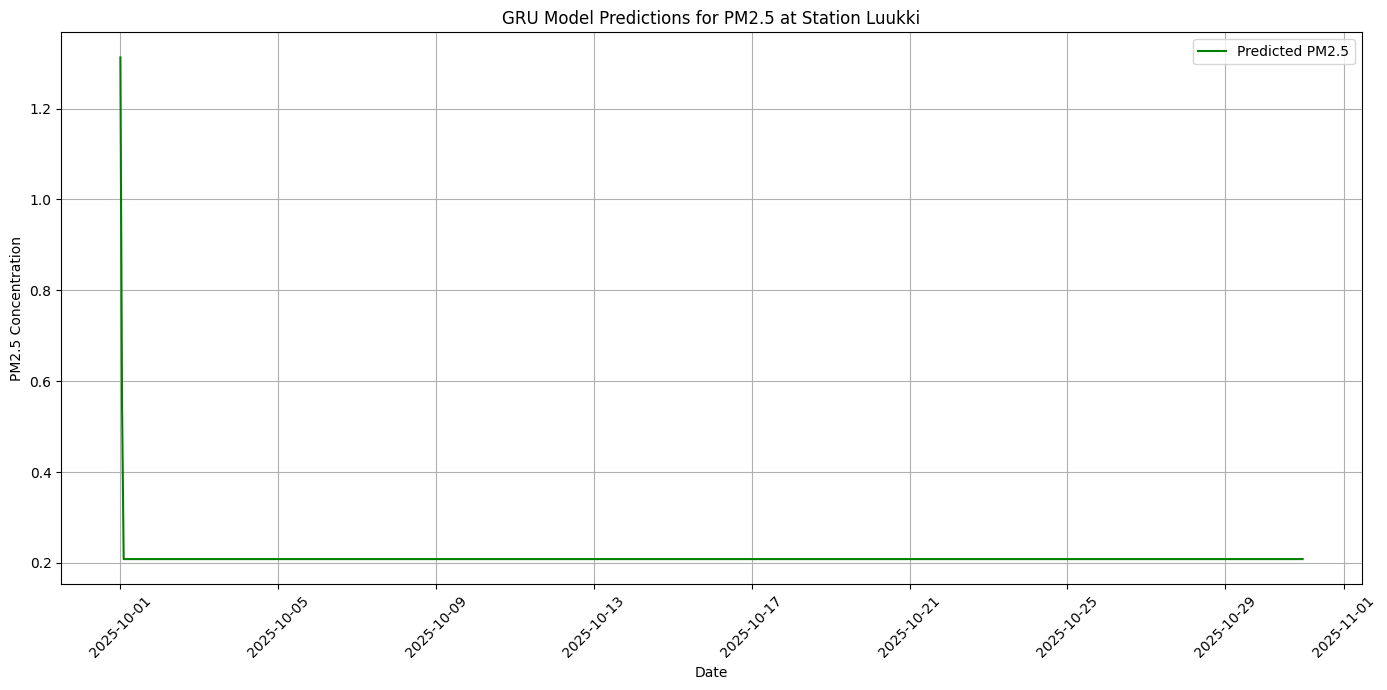

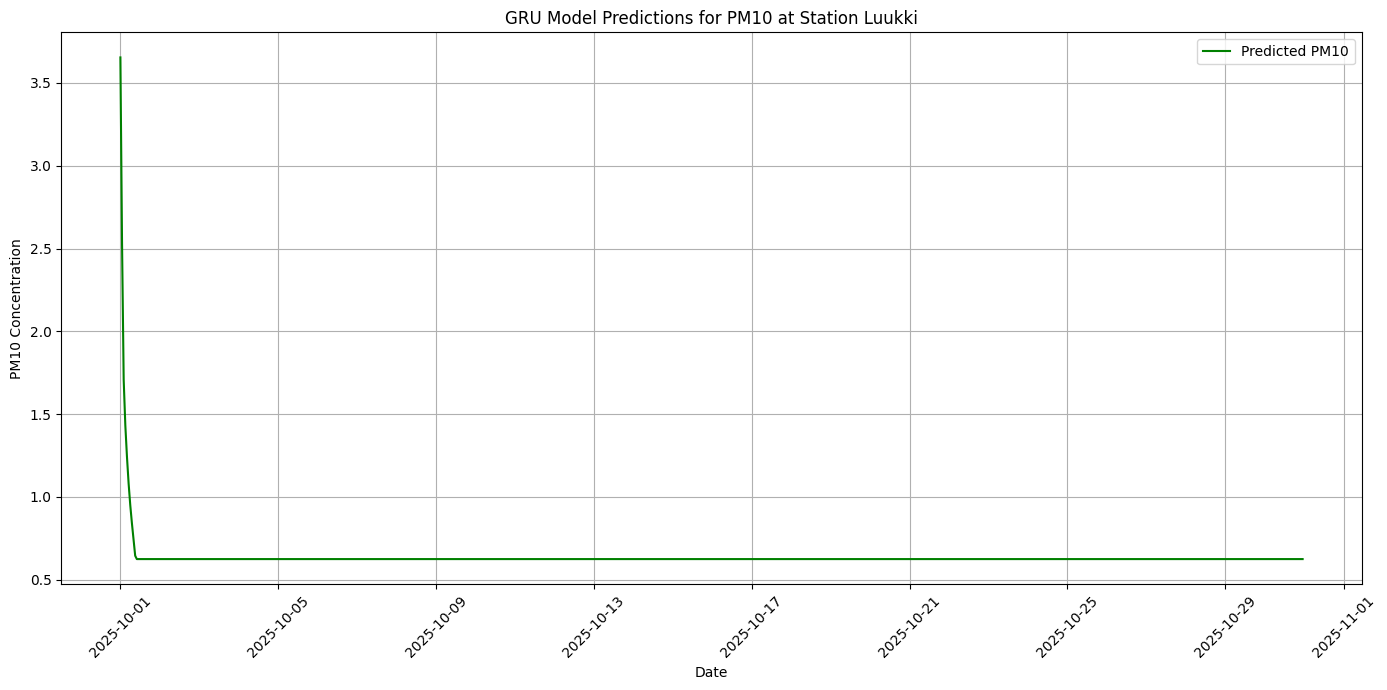

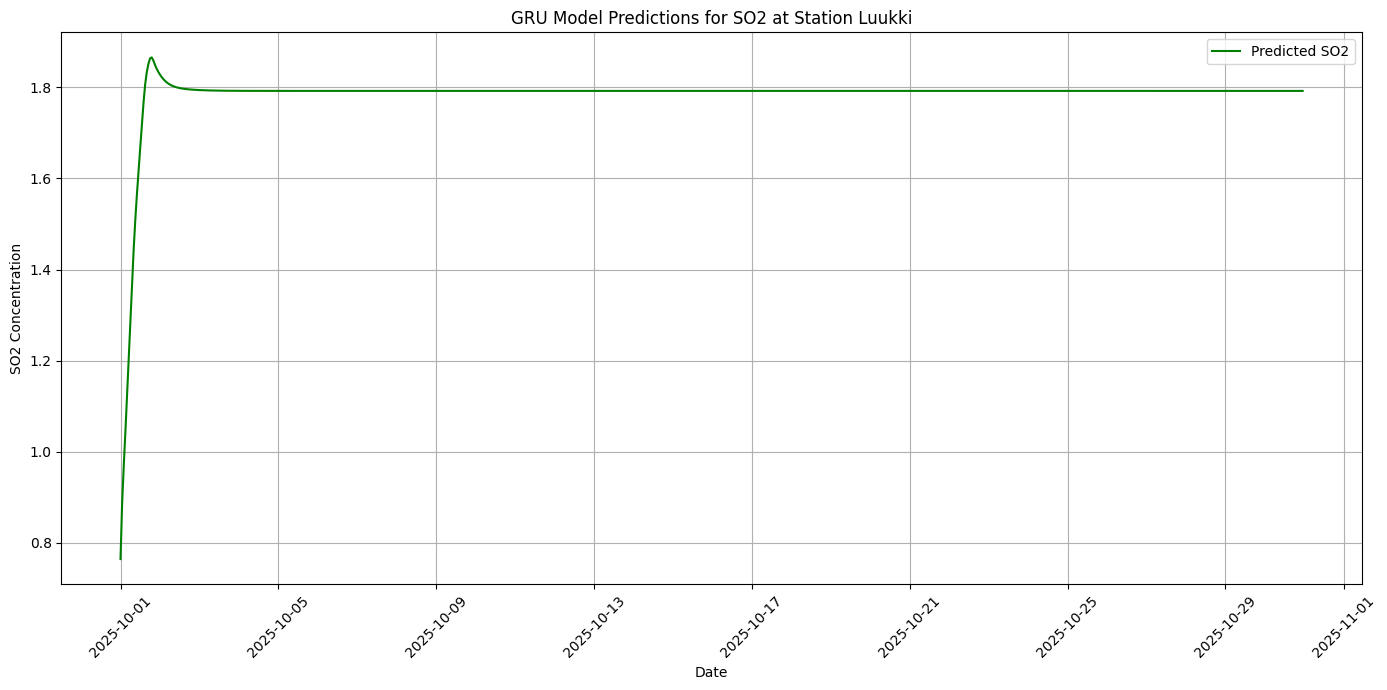

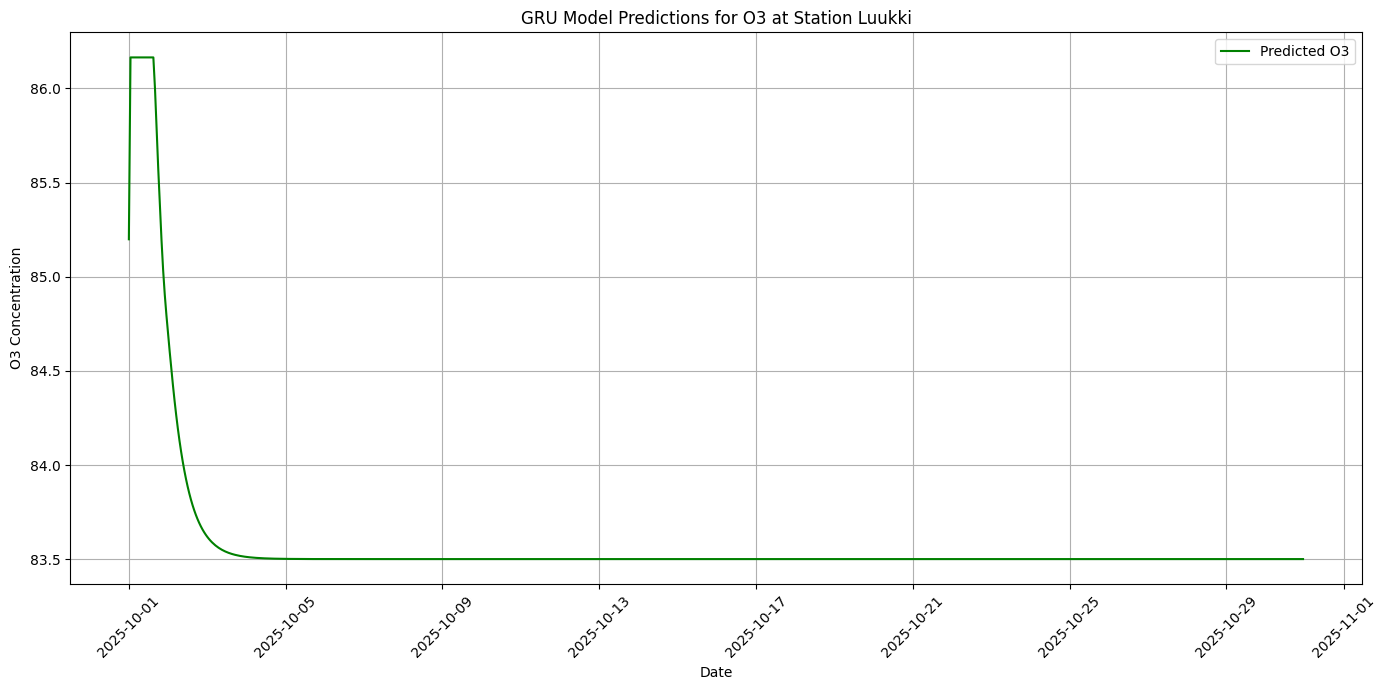

Predictions for station Luukki saved to predictions_station_Luukki.csv

Summary of Predictions for Station Luukki:
PM2.5:
  Minimum predicted level: 0.21
  Maximum predicted level: 1.31
  Average predicted level: 0.21
  Standard deviation: 0.04
PM10:
  Minimum predicted level: 0.62
  Maximum predicted level: 3.65
  Average predicted level: 0.64
  Standard deviation: 0.15
SO2:
  Minimum predicted level: 0.76
  Maximum predicted level: 1.87
  Average predicted level: 1.78
  Standard deviation: 0.08
O3:
  Minimum predicted level: 83.50
  Maximum predicted level: 86.16
  Average predicted level: 83.60
  Standard deviation: 0.44


Processing station: Ykspihlaja
No valid data after filling and cleaning for station Ykspihlaja
No valid data for station Ykspihlaja, skipping...


Processing station: Tirilä Pekkasenkatu
No valid data after filling and cleaning for station Tirilä Pekkasenkatu
No valid data for station Tirilä Pekkasenkatu, skipping...


Processing station: Ihalainen
No valid data a

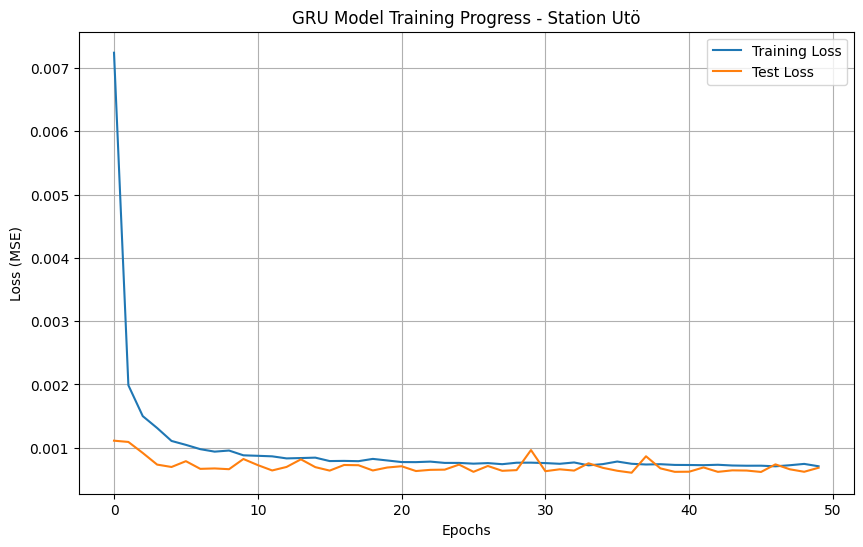

Evaluating model for station Utö...
Pollutant 6001 (PM2.5) Evaluation Metrics:
RMSE: 0.7993
MAE: 0.4066
Pollutant 5 (PM10) Evaluation Metrics:
RMSE: 4.6969
MAE: 1.1588
Pollutant 1 (SO2) Evaluation Metrics:
RMSE: 0.0620
MAE: 0.0377
Pollutant 7 (O3) Evaluation Metrics:
RMSE: 0.2926
MAE: 0.2084


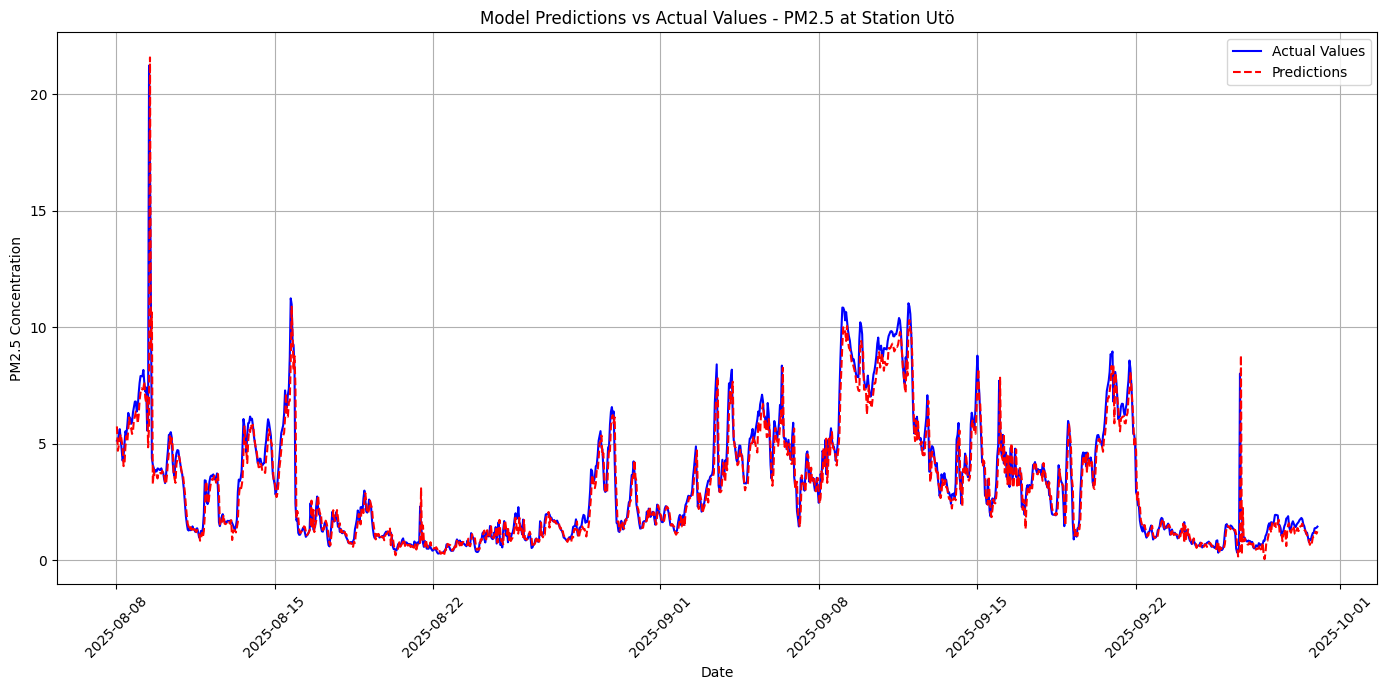

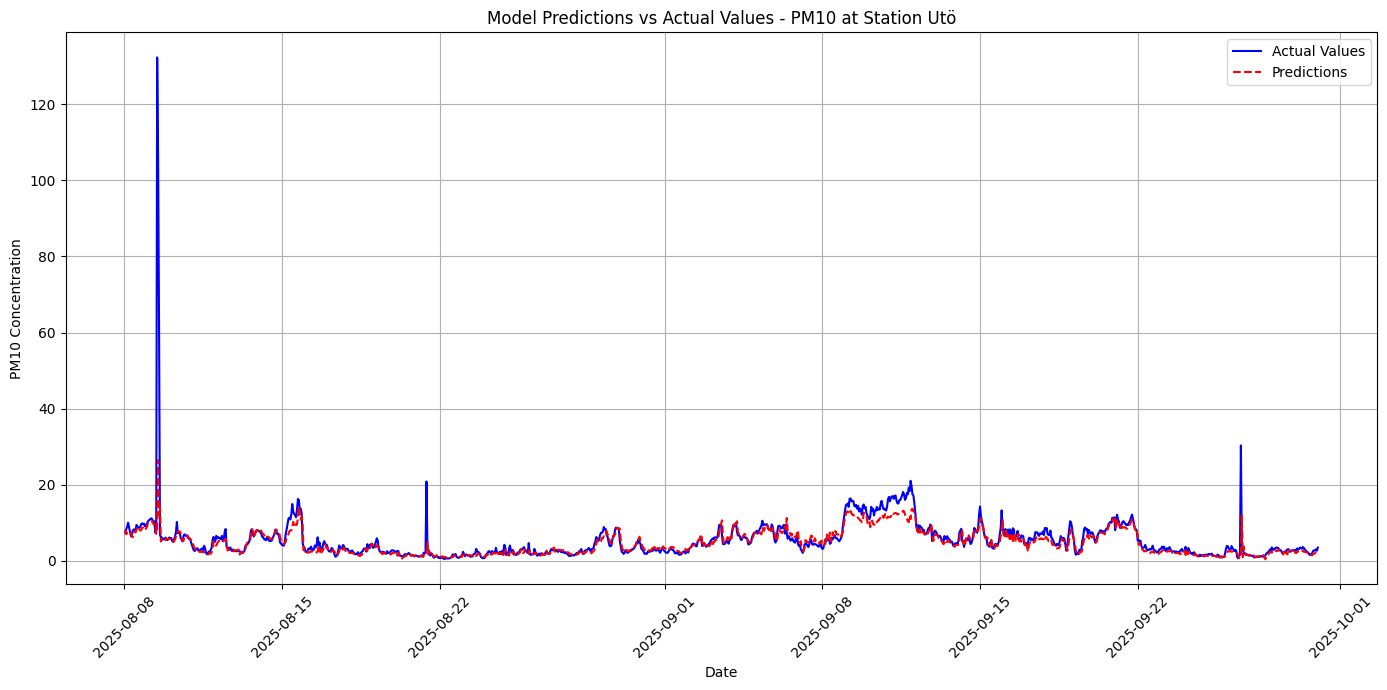

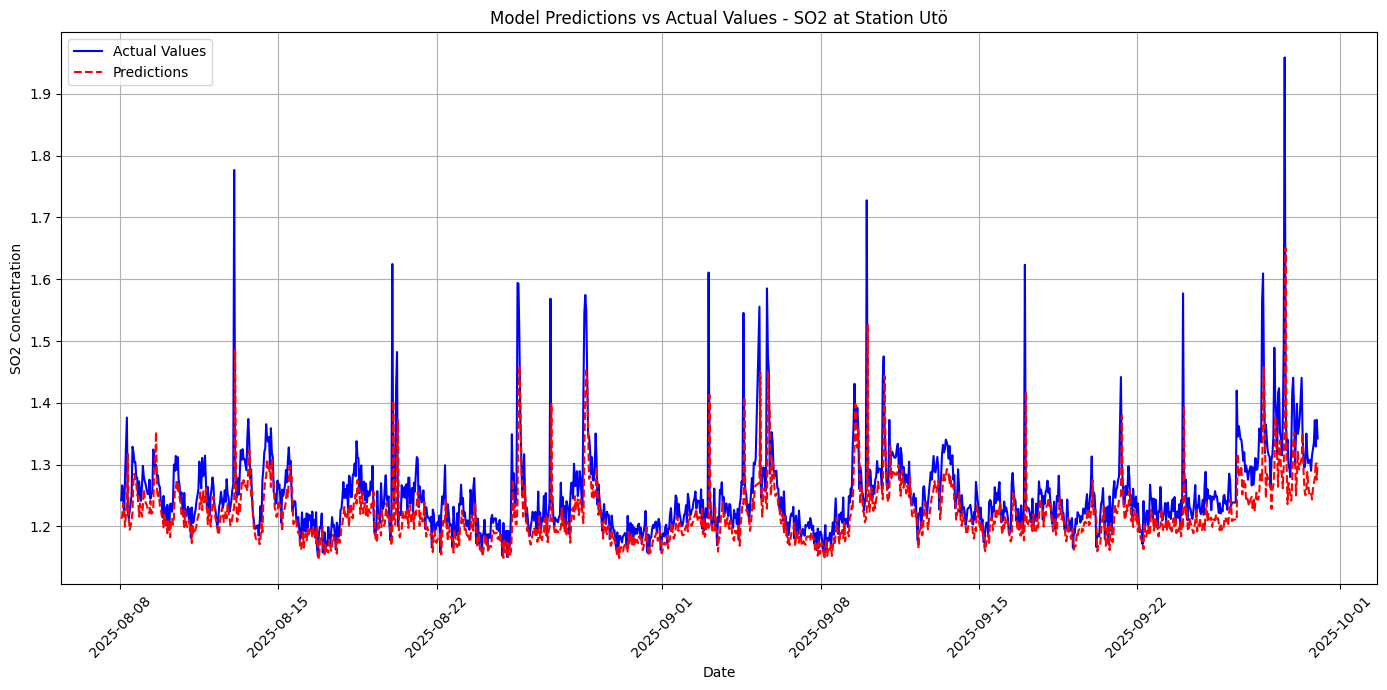

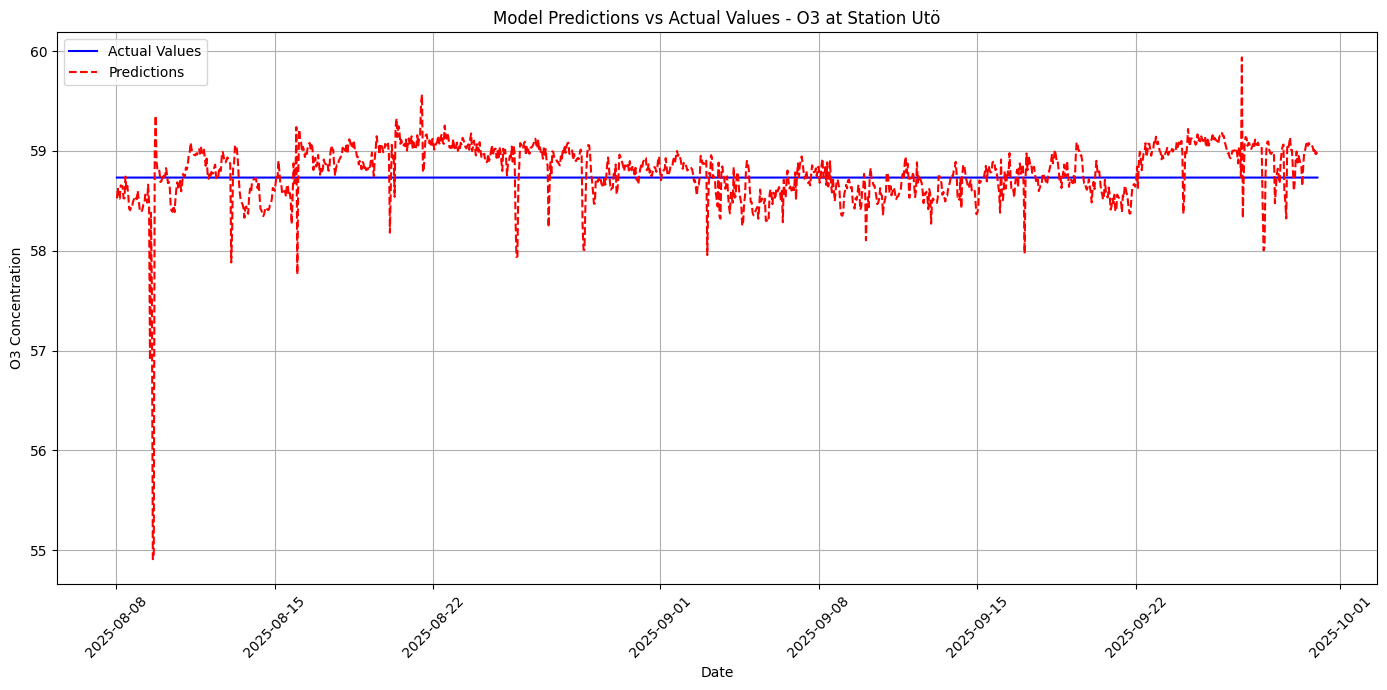

Making future predictions for station Utö...


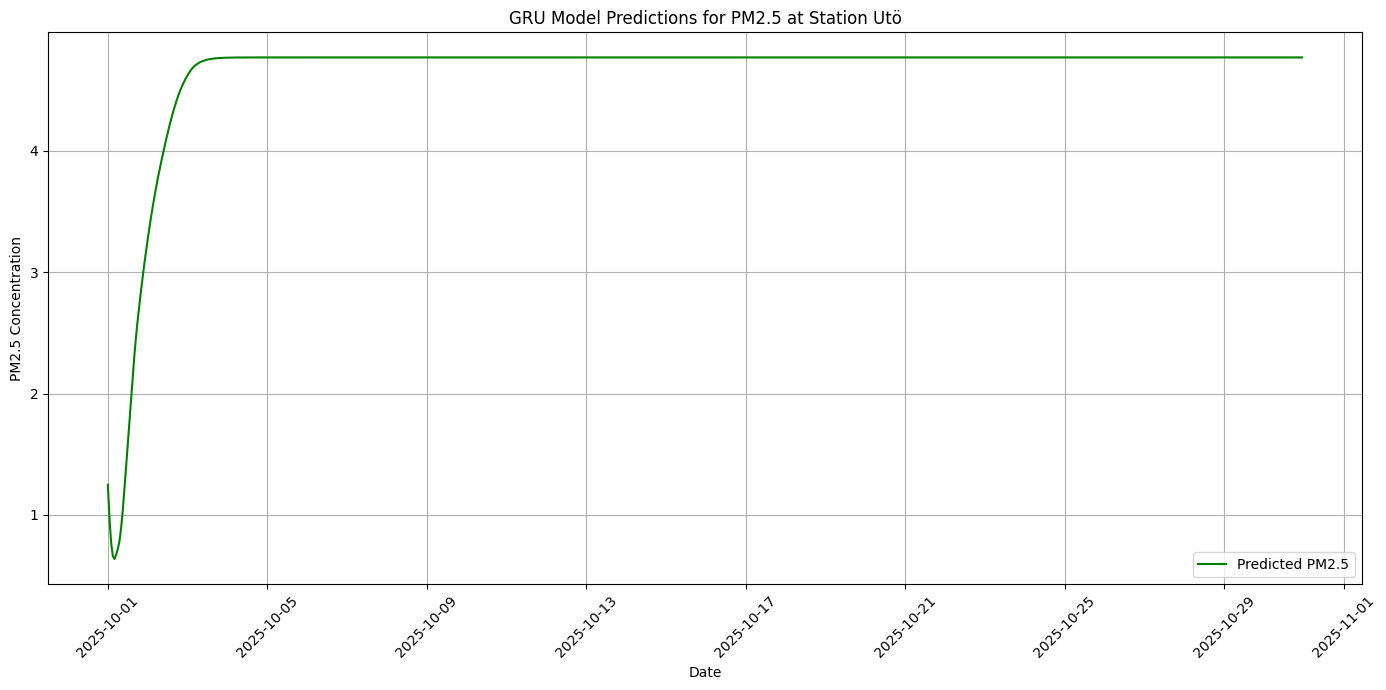

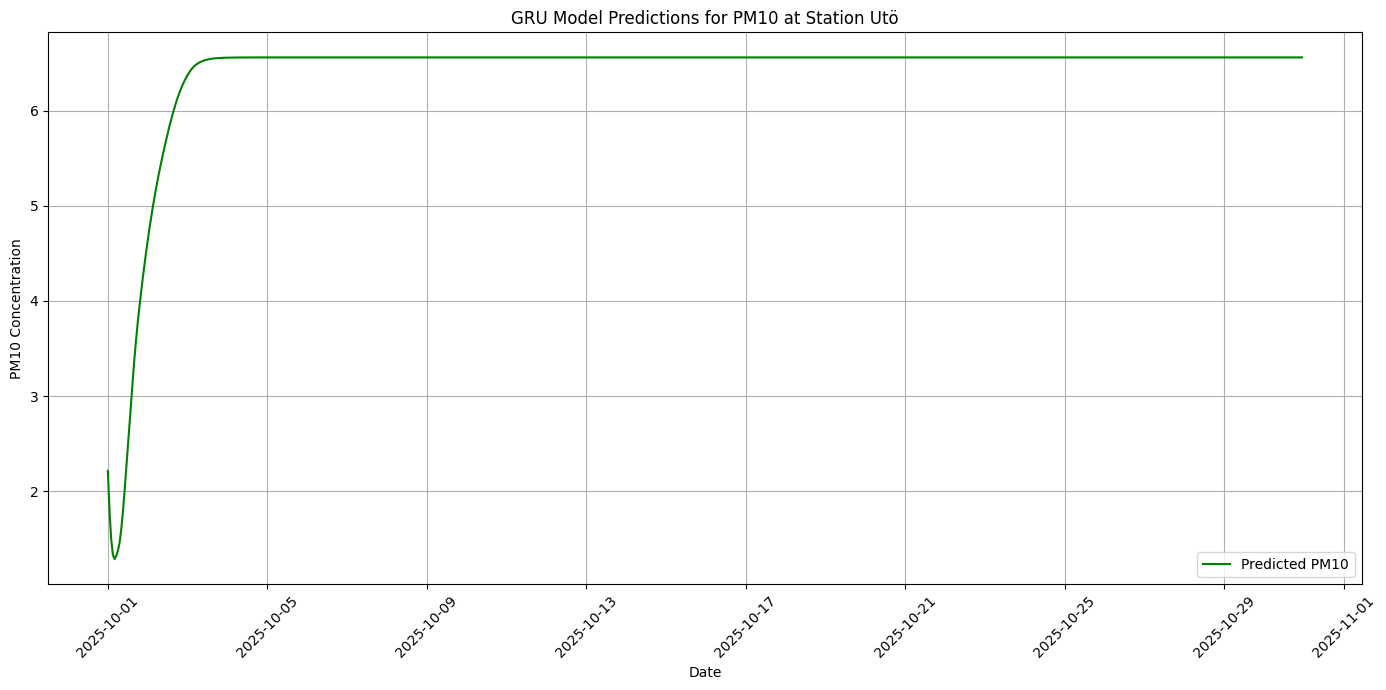

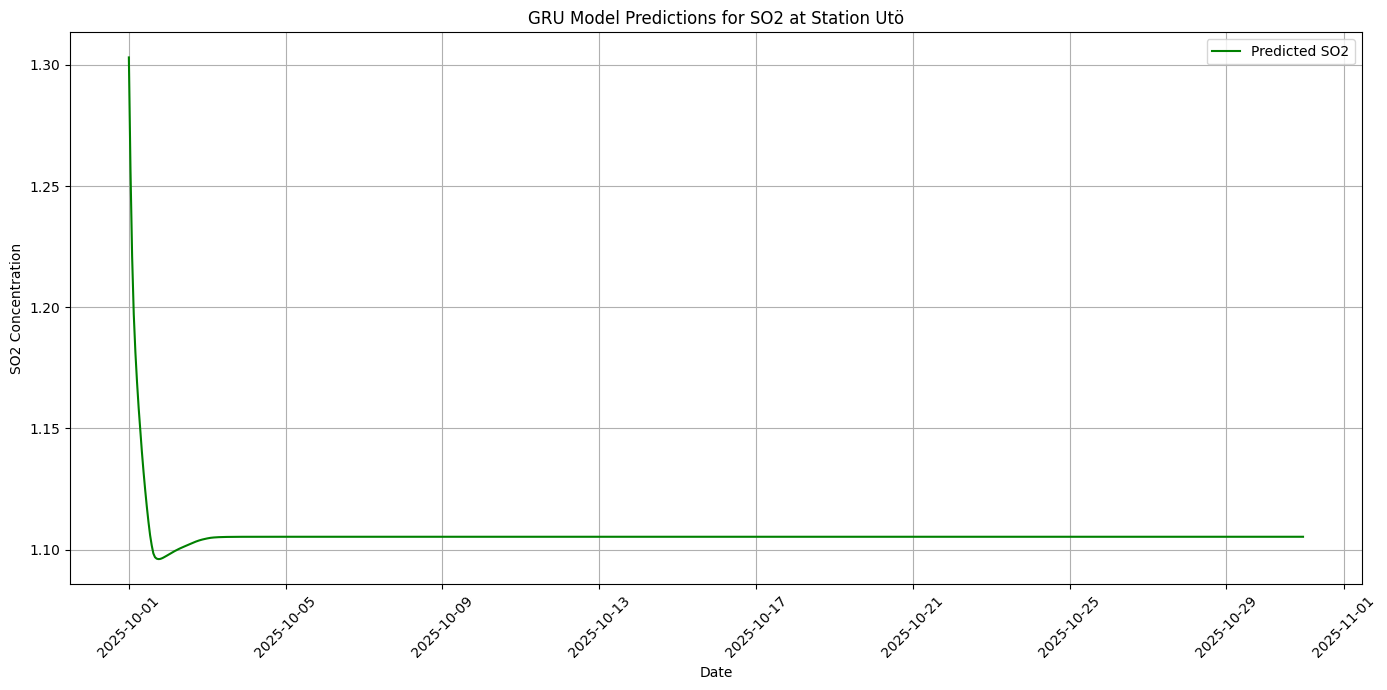

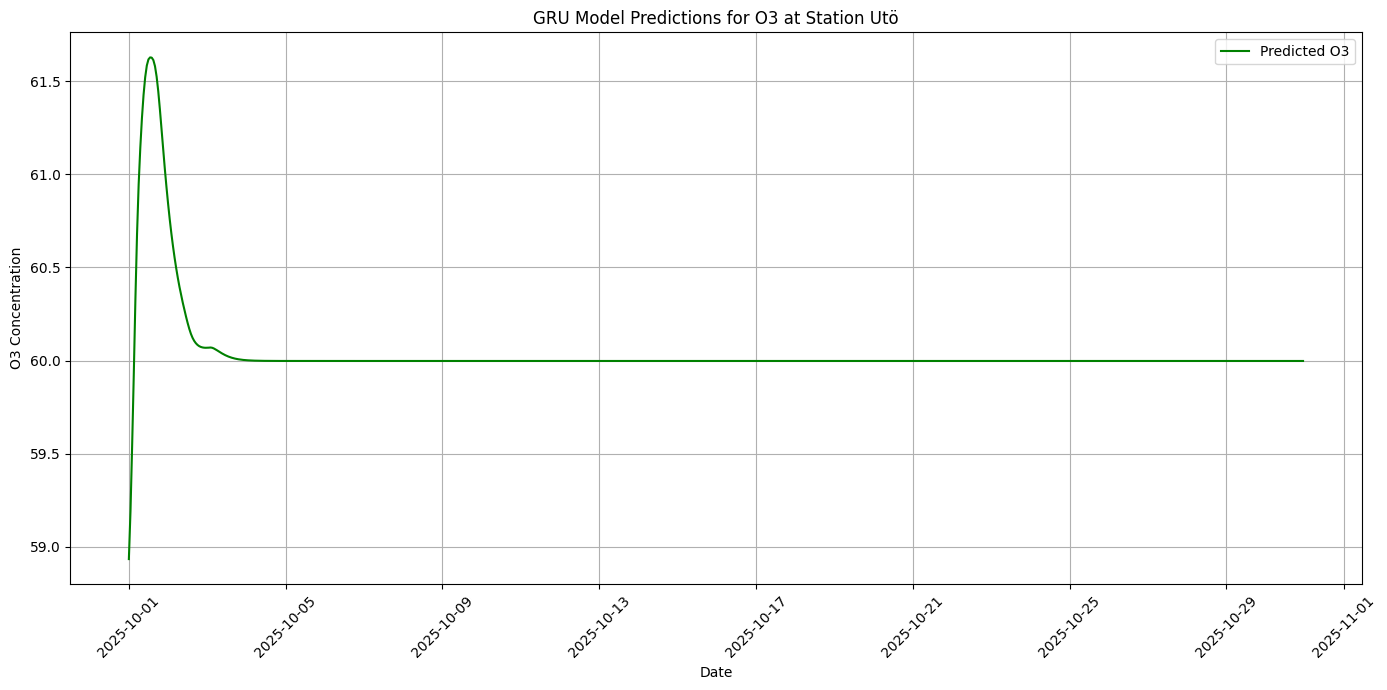

Predictions for station Utö saved to predictions_station_Utö.csv

Summary of Predictions for Station Utö:
PM2.5:
  Minimum predicted level: 0.64
  Maximum predicted level: 4.77
  Average predicted level: 4.64
  Standard deviation: 0.59
PM10:
  Minimum predicted level: 1.29
  Maximum predicted level: 6.56
  Average predicted level: 6.40
  Standard deviation: 0.75
SO2:
  Minimum predicted level: 1.10
  Maximum predicted level: 1.30
  Average predicted level: 1.11
  Standard deviation: 0.01
O3:
  Minimum predicted level: 58.93
  Maximum predicted level: 61.63
  Average predicted level: 60.04
  Standard deviation: 0.23


Processing station: Oulanka
No valid data after filling and cleaning for station Oulanka
No valid data for station Oulanka, skipping...


Processing station: Sammaltunturi
Prepared 6502 samples for station Sammaltunturi
Train samples: 5201, Test samples: 1301
Training model for station Sammaltunturi...
Epoch [10/50], Train Loss: 0.0006, Test Loss: 0.0002
Epoch [20/50], Tra

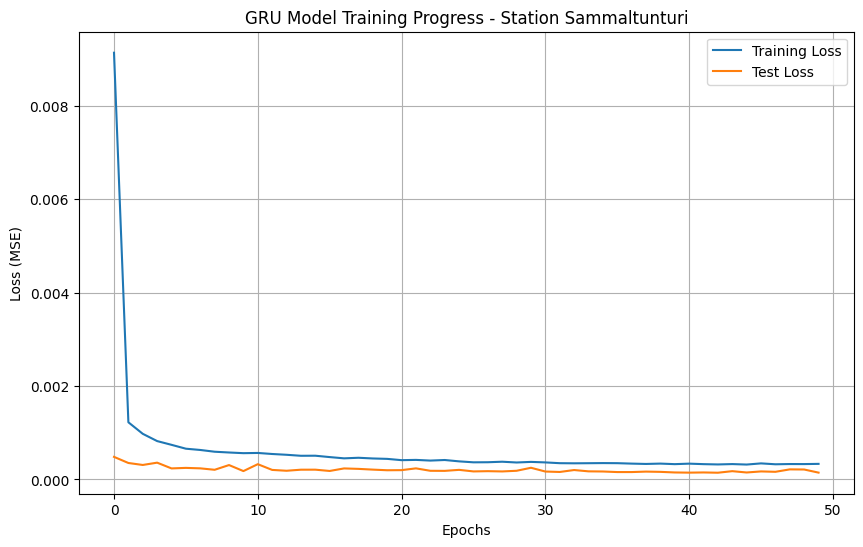

Evaluating model for station Sammaltunturi...
Pollutant 6001 (PM2.5) Evaluation Metrics:
RMSE: 0.4509
MAE: 0.2600
Pollutant 5 (PM10) Evaluation Metrics:
RMSE: 0.8578
MAE: 0.6032
Pollutant 1 (SO2) Evaluation Metrics:
RMSE: 0.0650
MAE: 0.0418
Pollutant 7 (O3) Evaluation Metrics:
RMSE: 0.1253
MAE: 0.0974


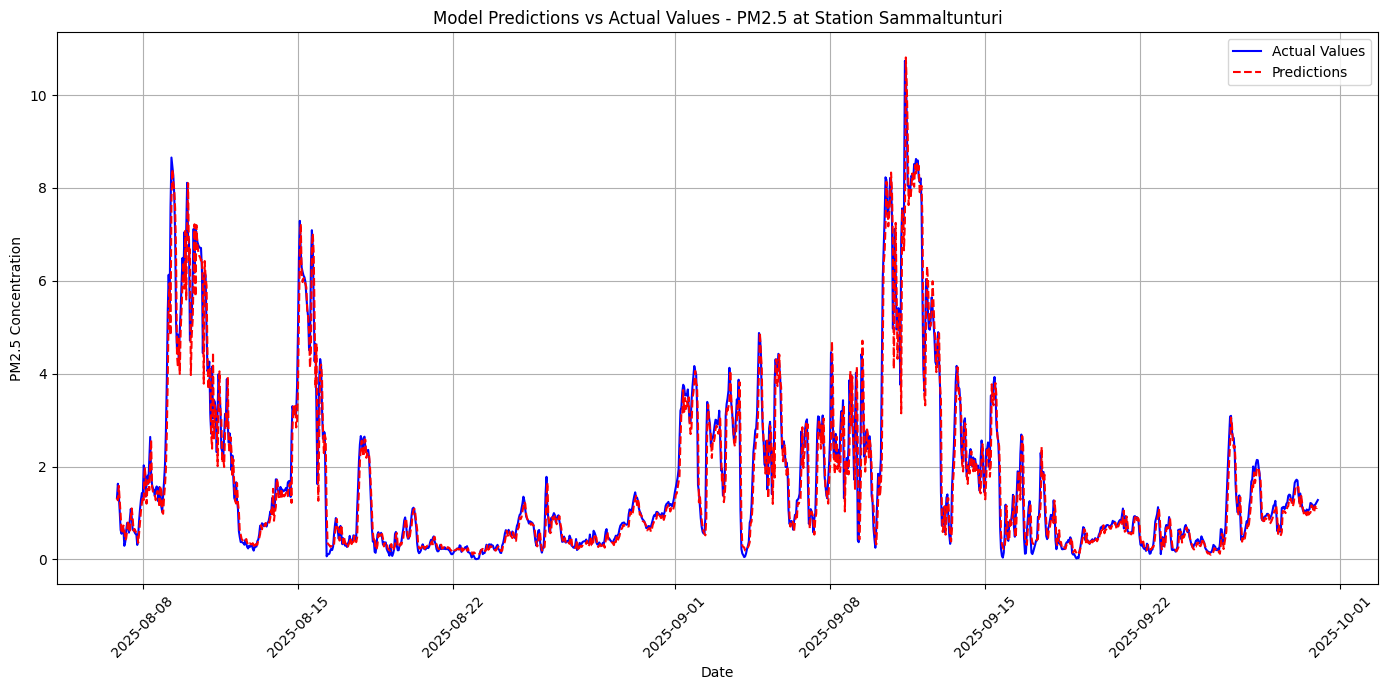

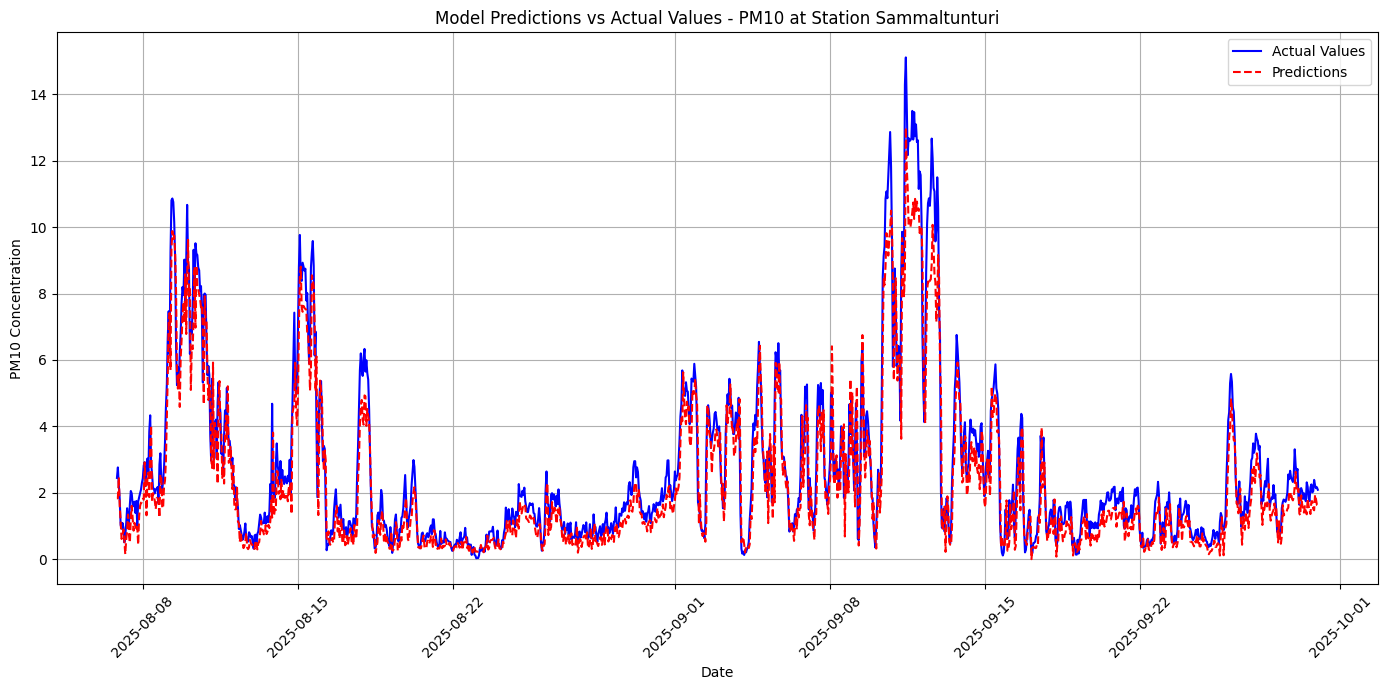

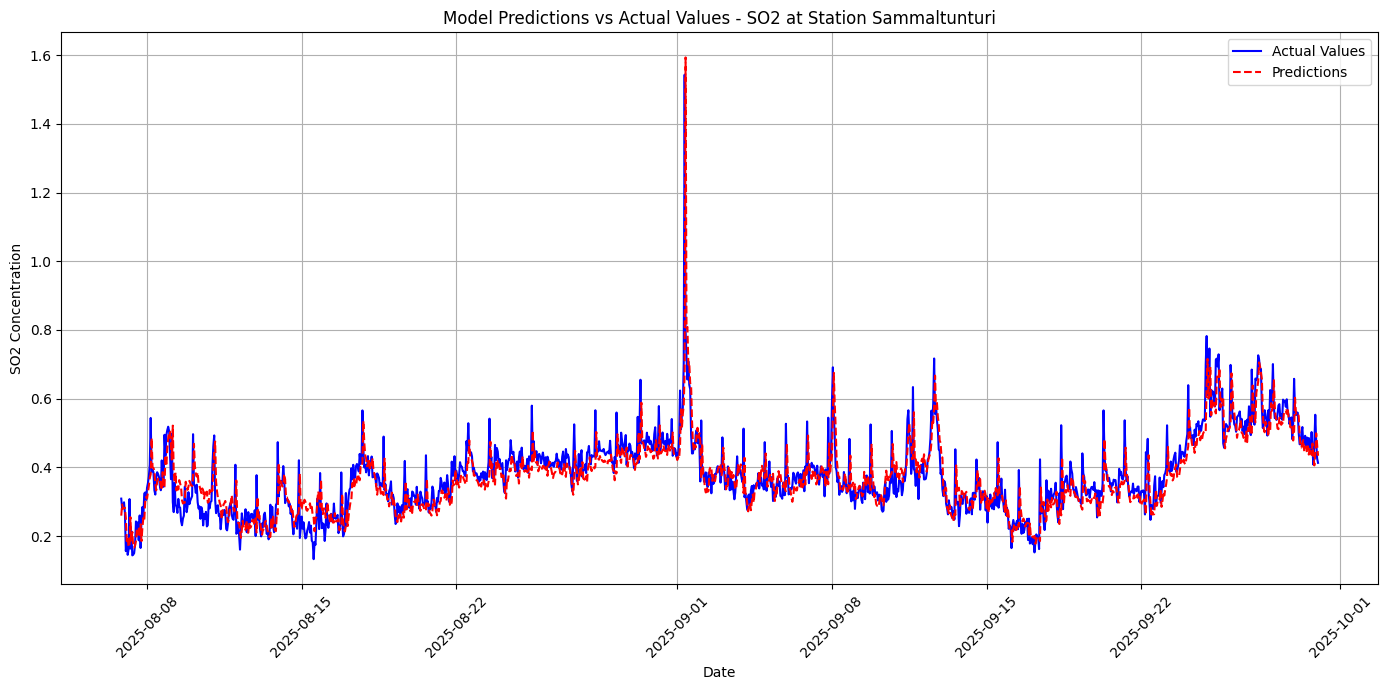

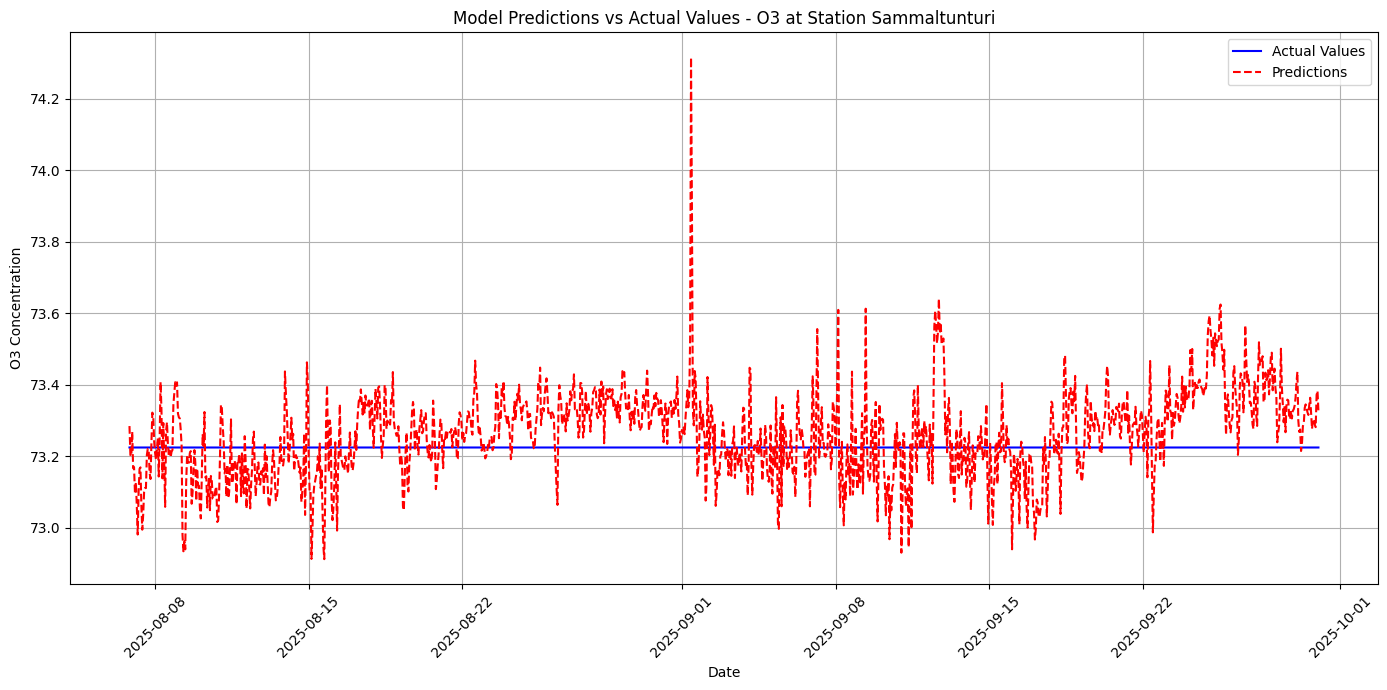

Making future predictions for station Sammaltunturi...


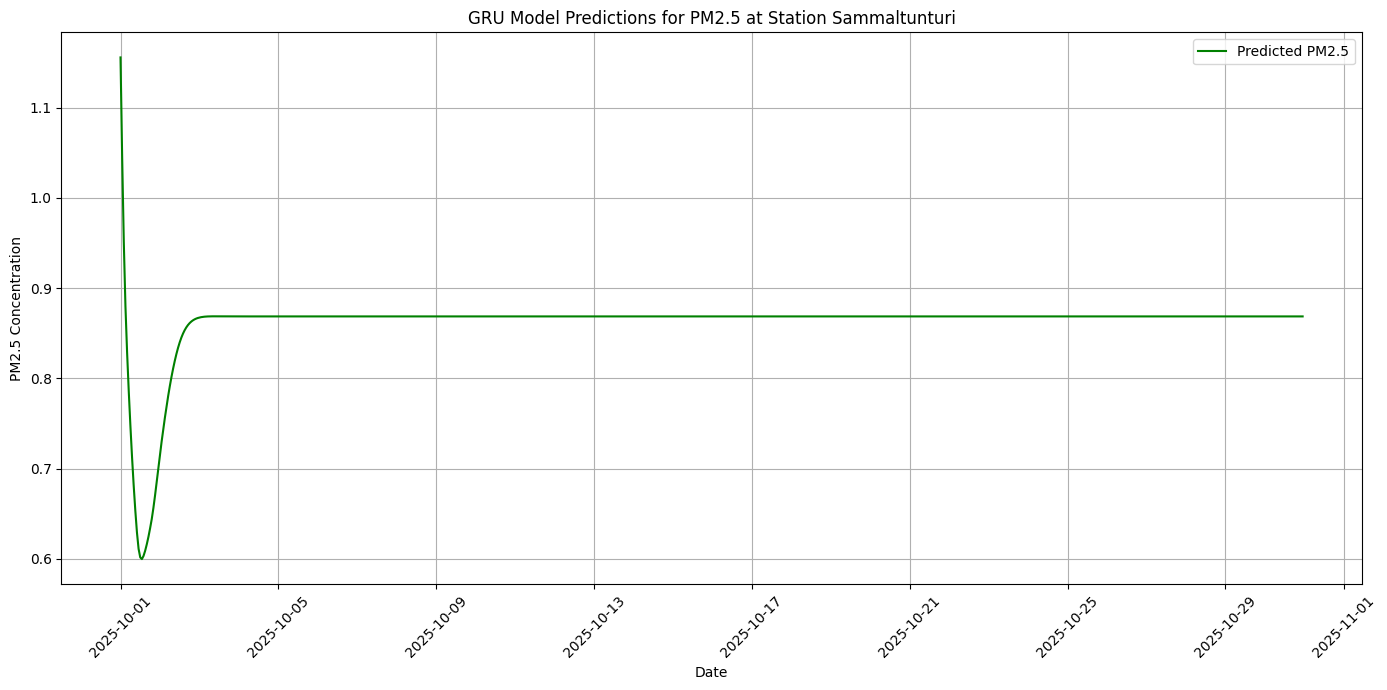

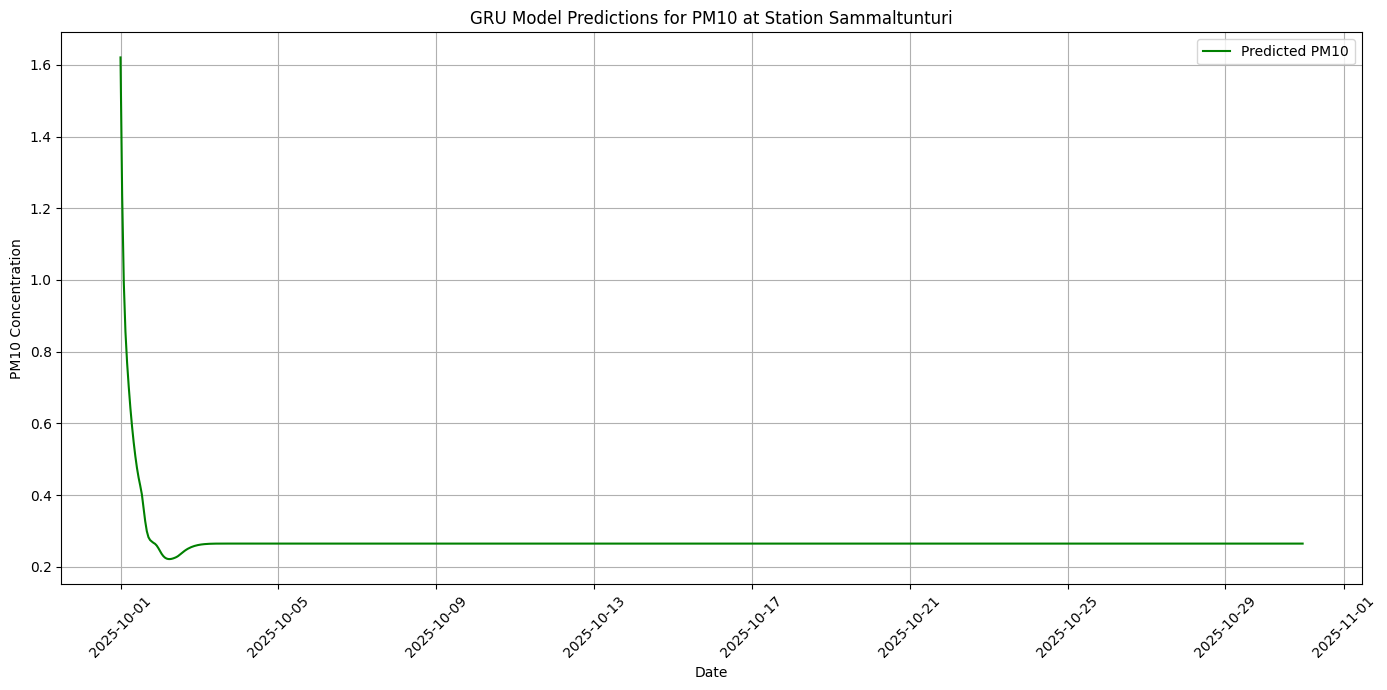

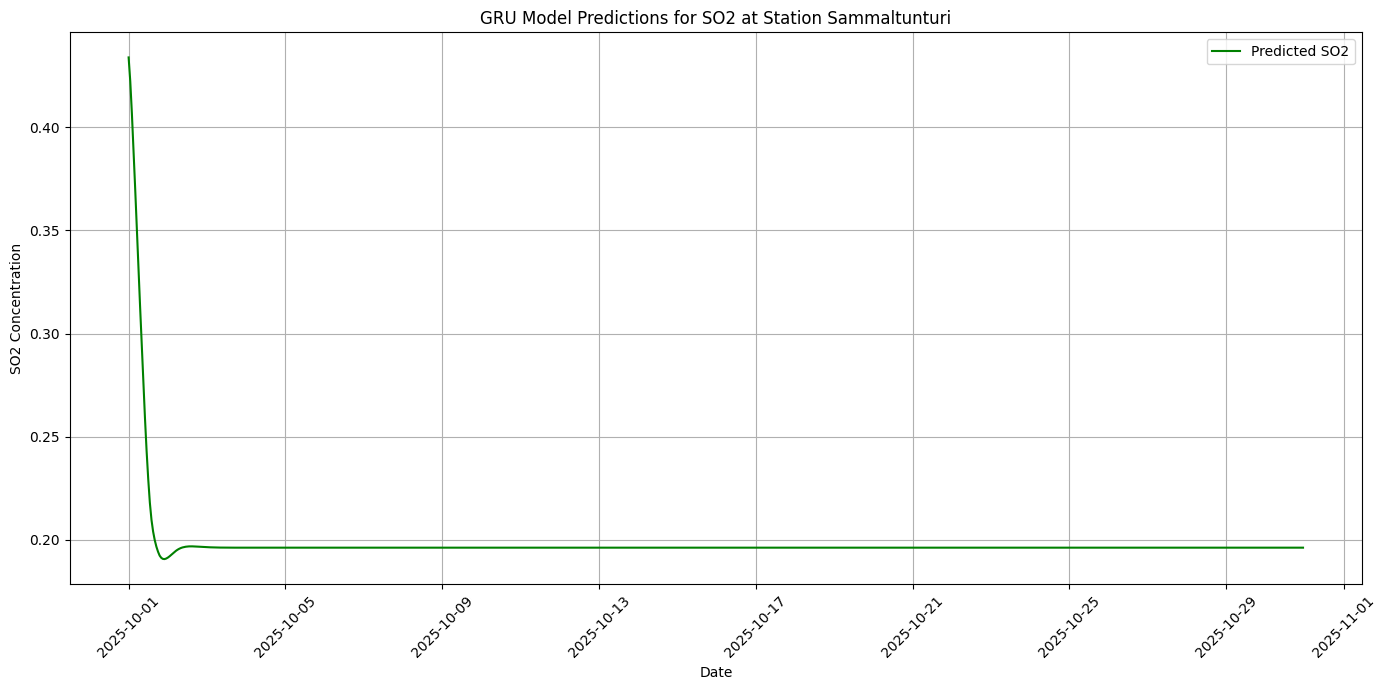

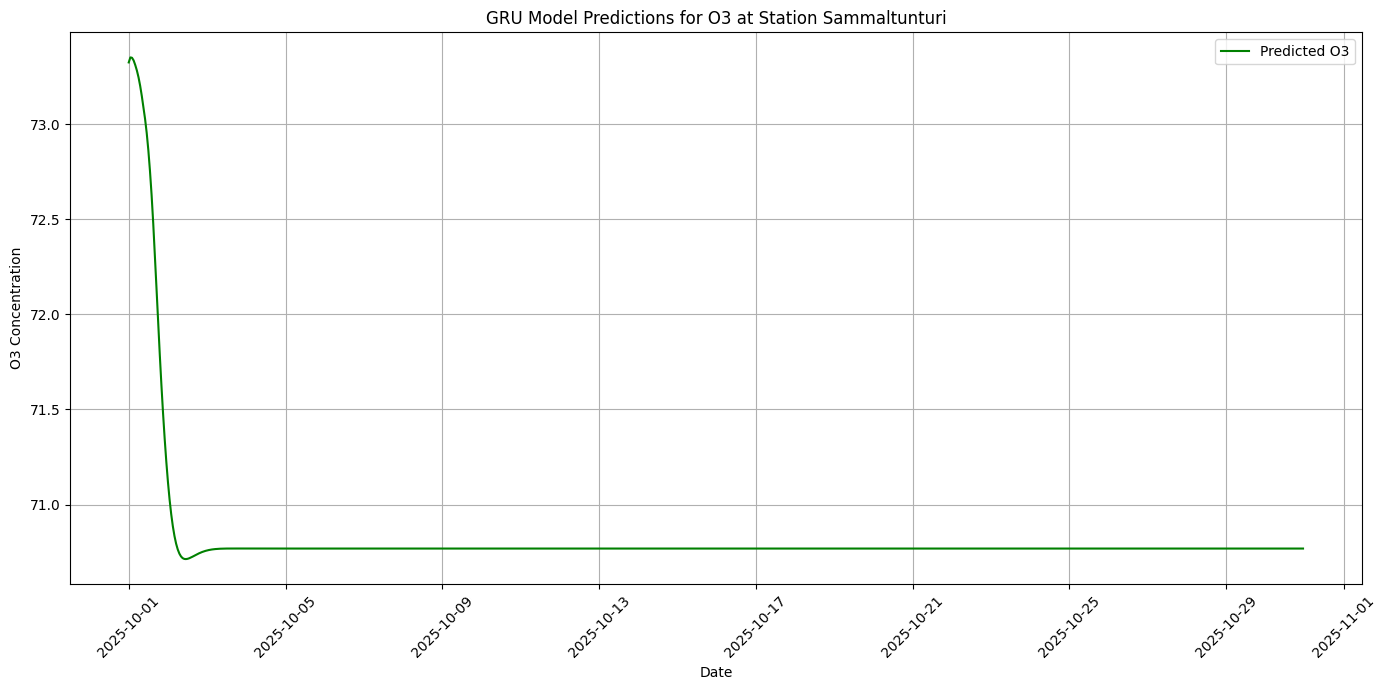

Predictions for station Sammaltunturi saved to predictions_station_Sammaltunturi.csv

Summary of Predictions for Station Sammaltunturi:
PM2.5:
  Minimum predicted level: 0.60
  Maximum predicted level: 1.16
  Average predicted level: 0.86
  Standard deviation: 0.04
PM10:
  Minimum predicted level: 0.22
  Maximum predicted level: 1.62
  Average predicted level: 0.27
  Standard deviation: 0.08
SO2:
  Minimum predicted level: 0.19
  Maximum predicted level: 0.43
  Average predicted level: 0.20
  Standard deviation: 0.02
O3:
  Minimum predicted level: 70.71
  Maximum predicted level: 73.35
  Average predicted level: 70.83
  Standard deviation: 0.36


Processing station: Raja-Jooseppi
No valid data after filling and cleaning for station Raja-Jooseppi
No valid data for station Raja-Jooseppi, skipping...


Processing station: Lapaluoto
No valid data after filling and cleaning for station Lapaluoto
No valid data for station Lapaluoto, skipping...


Processing station: Tikkurila 3
No valid data

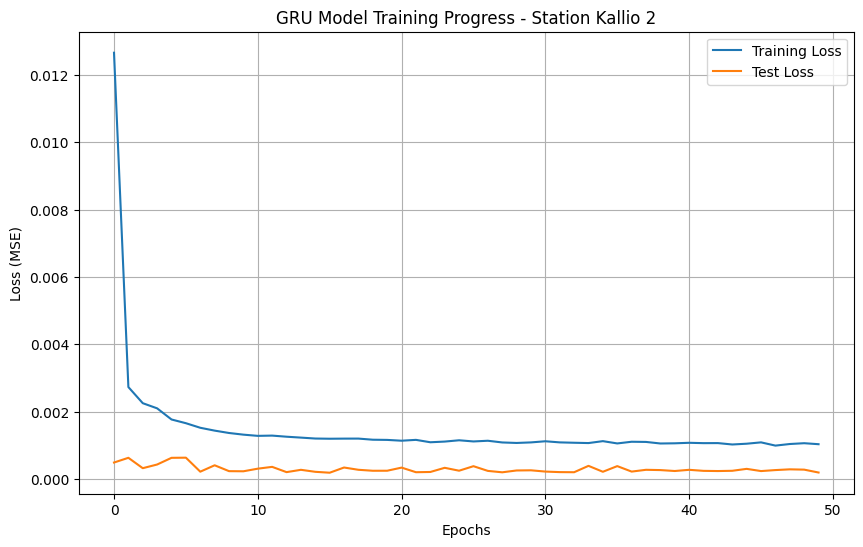

Evaluating model for station Kallio 2...
Pollutant 6001 (PM2.5) Evaluation Metrics:
RMSE: 1.0277
MAE: 0.5767
Pollutant 5 (PM10) Evaluation Metrics:
RMSE: 2.8269
MAE: 1.4970
Pollutant 1 (SO2) Evaluation Metrics:
RMSE: 0.2513
MAE: 0.1472
Pollutant 7 (O3) Evaluation Metrics:
RMSE: 0.2545
MAE: 0.1827


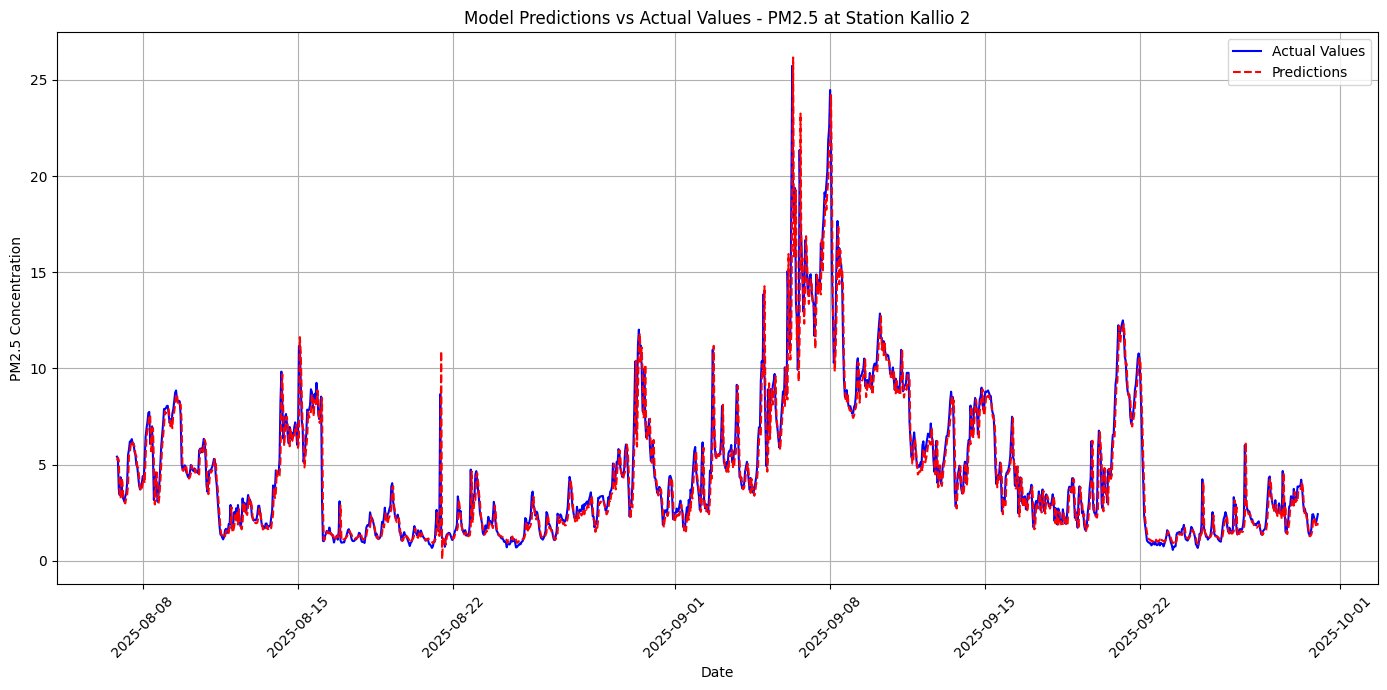

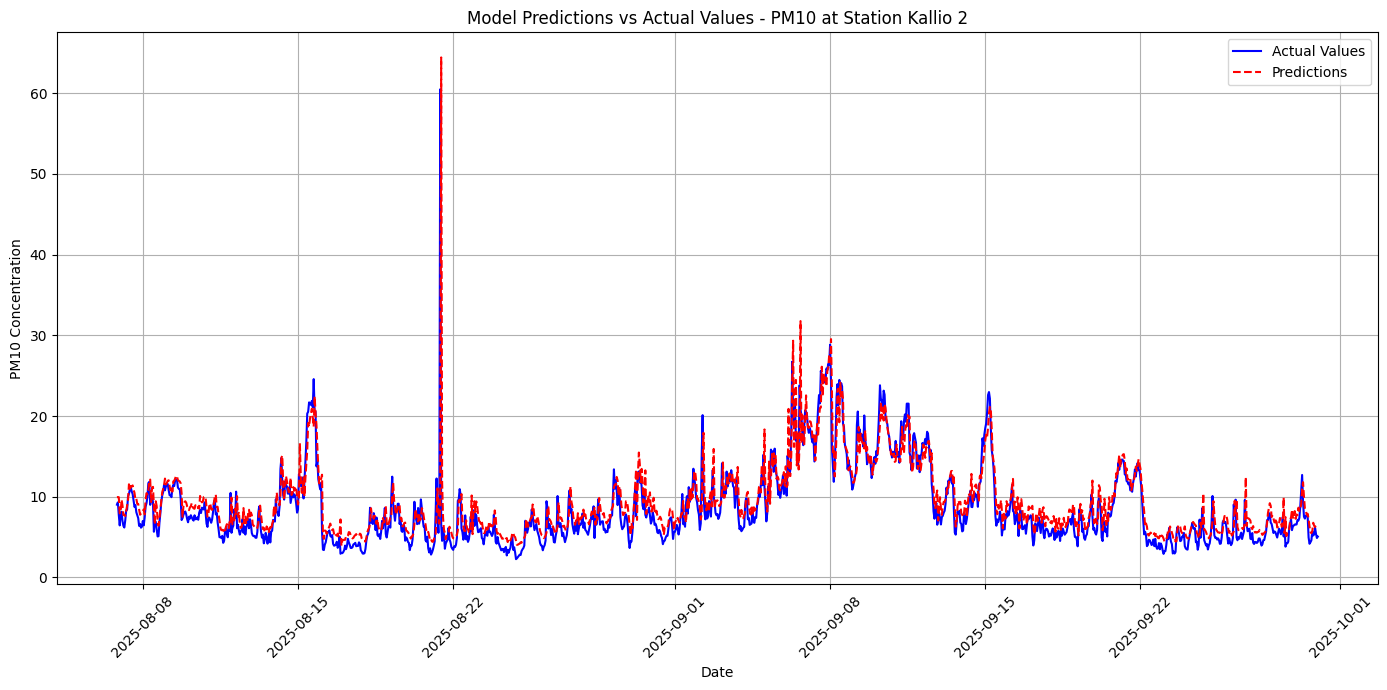

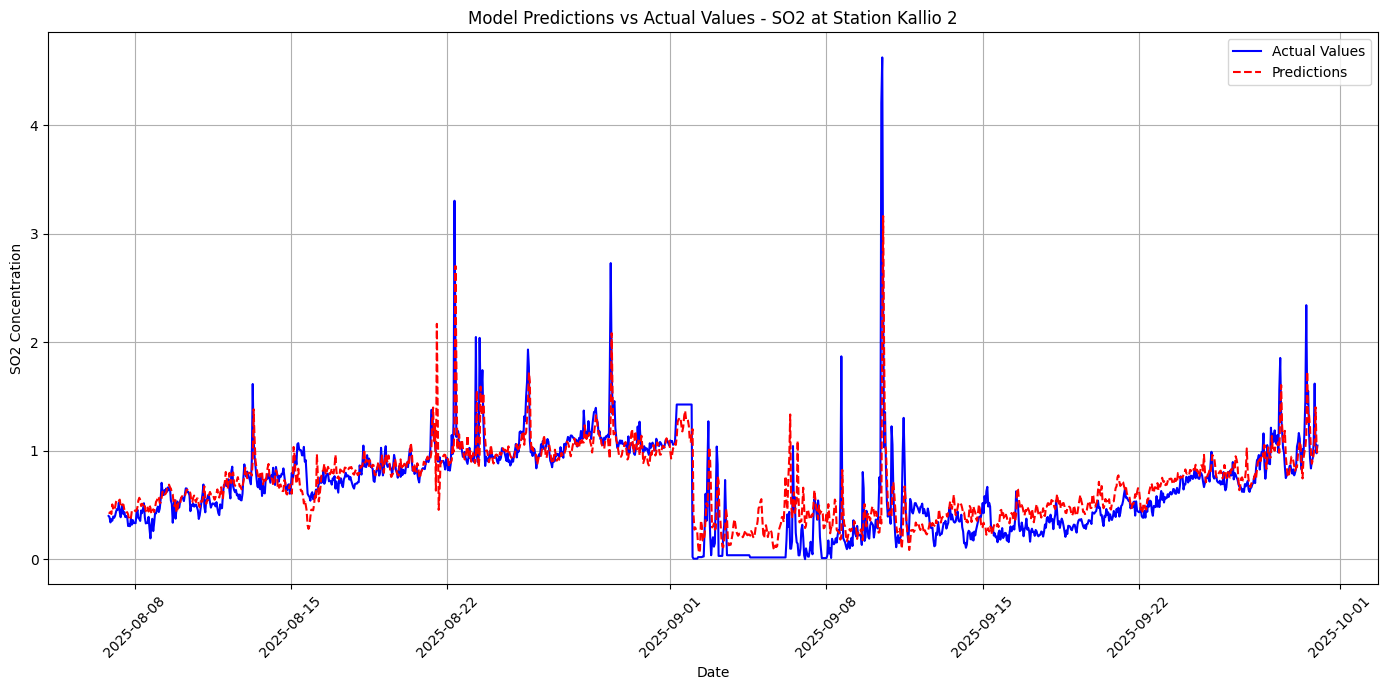

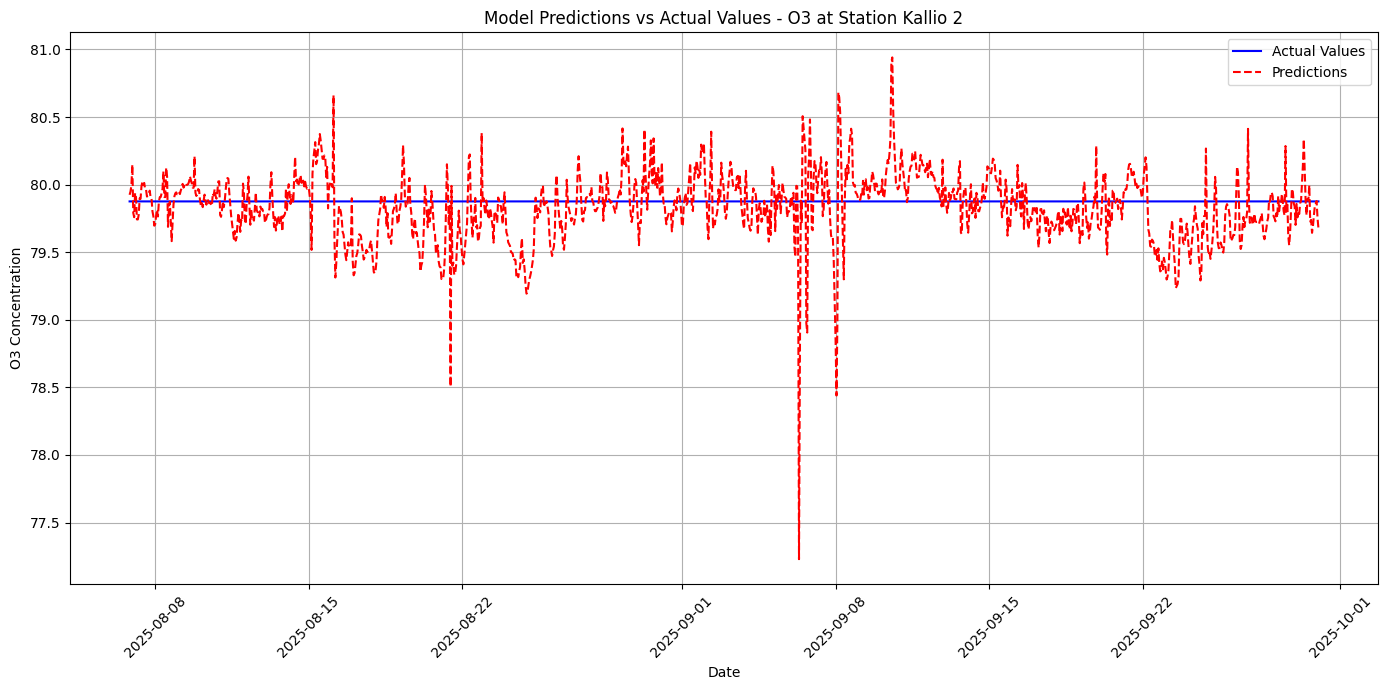

Making future predictions for station Kallio 2...


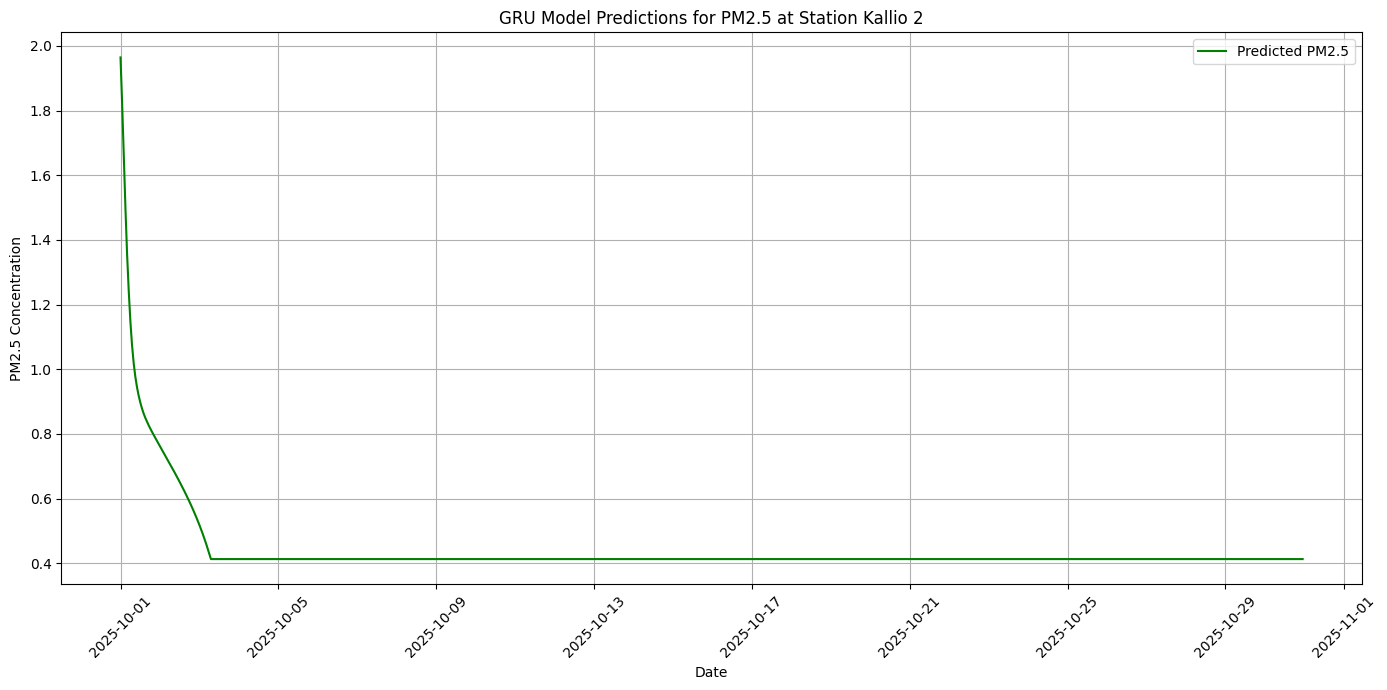

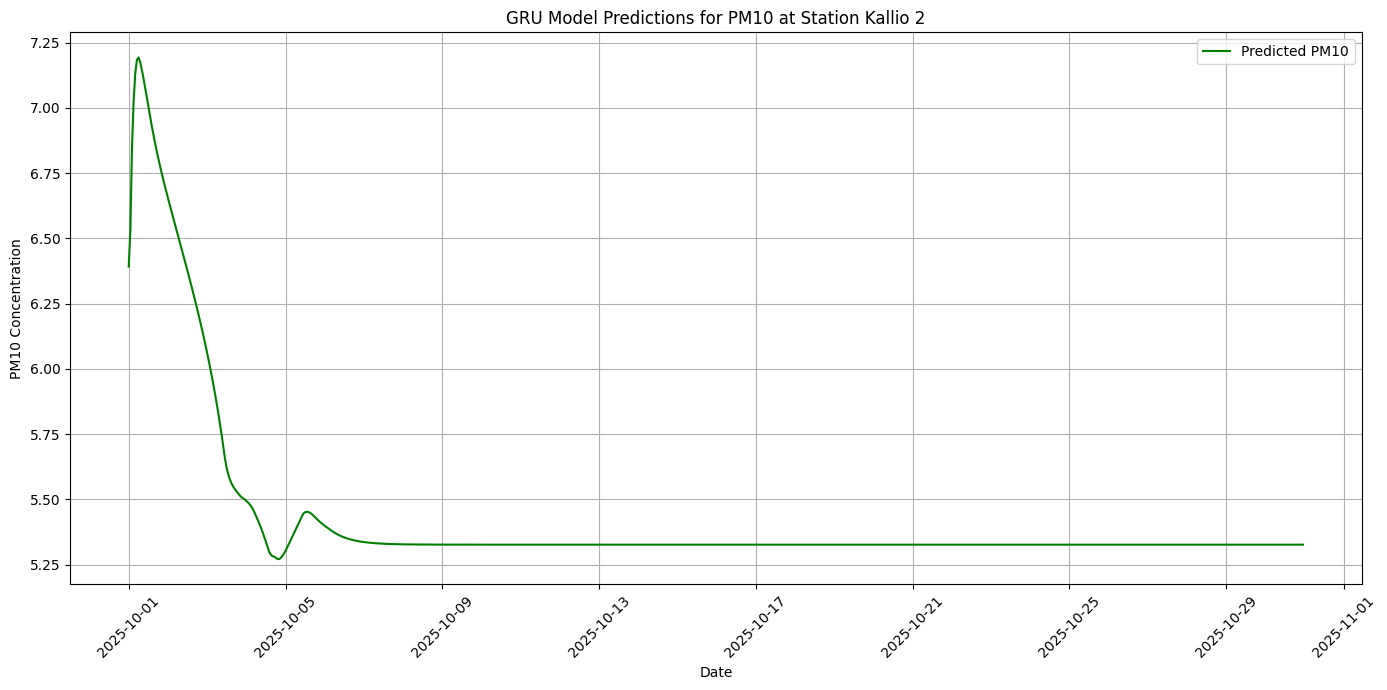

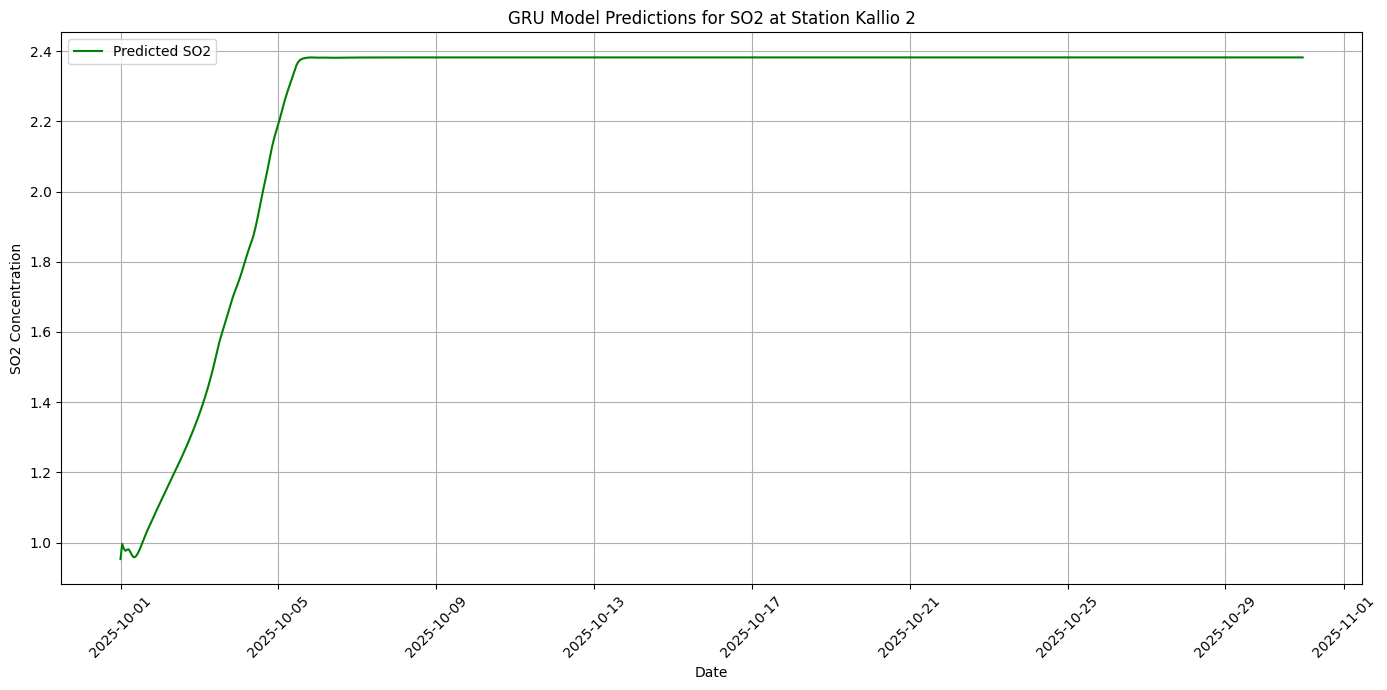

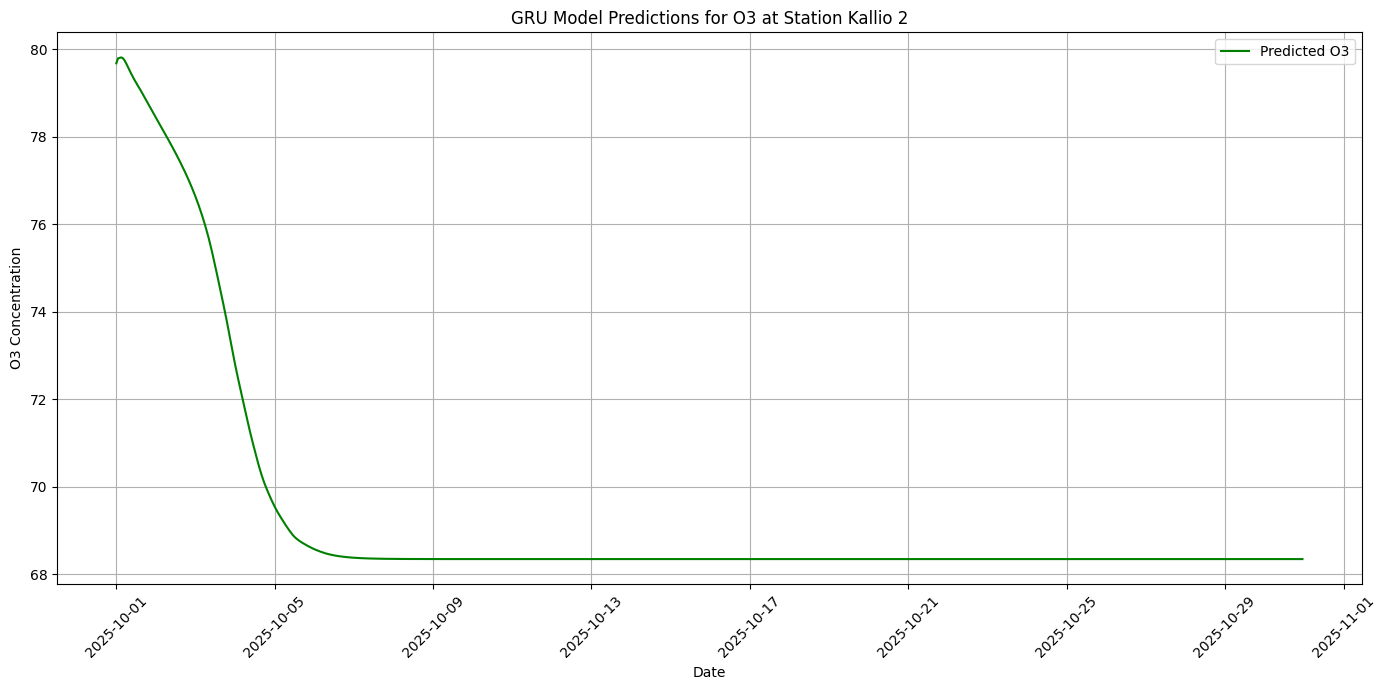

Predictions for station Kallio 2 saved to predictions_station_Kallio_2.csv

Summary of Predictions for Station Kallio 2:
PM2.5:
  Minimum predicted level: 0.41
  Maximum predicted level: 1.96
  Average predicted level: 0.44
  Standard deviation: 0.14
PM10:
  Minimum predicted level: 5.27
  Maximum predicted level: 7.19
  Average predicted level: 5.43
  Standard deviation: 0.34
SO2:
  Minimum predicted level: 0.95
  Maximum predicted level: 2.38
  Average predicted level: 2.25
  Standard deviation: 0.35
O3:
  Minimum predicted level: 68.35
  Maximum predicted level: 79.81
  Average predicted level: 69.36
  Standard deviation: 2.76


Processing station: Matorova
No valid data after filling and cleaning for station Matorova
No valid data for station Matorova, skipping...


Processing station: Ilomantsi
No valid data after filling and cleaning for station Ilomantsi
No valid data for station Ilomantsi, skipping...


Processing station: Palokka 2
No valid data after filling and cleaning for 

KeyboardInterrupt: 

In [14]:


# 主函数 - 按站点名称分组预测
def main():
    if not df_air.empty:
        # 确定是按站点名称还是采样点ID进行分组
        if 'Air Quality Station Name' in df_air.columns:
            # 按站点名称分组
            station_names = df_air['Air Quality Station Name'].unique()
            print(f'Processing {len(station_names)} air quality stations...')
        else:
            # 回退到使用采样点ID
            station_names = df_air['Samplingpoint'].unique()
            print(f'Processing {len(station_names)} sampling stations...')
        
        pollutant_ids = list(POLLUTANTS.keys())
        sequence_length = 24
        
        # 为每个站点分别训练模型和预测
        for station_name in station_names:
            print(f'\n\nProcessing station: {station_name}')
            
            try:
                # 准备数据
                X, y, scalers, dates = prepare_multi_pollutant_data(
                    df_air, pollutant_ids, station_name, sequence_length
                )
                
                if len(X) == 0:
                    print(f'No valid data for station {station_name}, skipping...')
                    continue
                
                print(f'Prepared {X.shape[0]} samples for station {station_name}')
                
                # 将数据分为训练集和测试集
                train_size = int(0.8 * len(X))
                X_train, X_test = X[:train_size], X[train_size:]
                y_train, y_test = y[:train_size], y[train_size:]
                test_dates = dates[train_size:]
                
                # 获取有效的污染物ID（在scalers中有缩放器的）
                valid_pollutant_ids = list(scalers.keys())
                if not valid_pollutant_ids:
                    print(f'No valid pollutant scalers for station {station_name}, skipping...')
                    continue                
                print(f'Train samples: {len(X_train)}, Test samples: {len(X_test)}')

                
                # 创建DataLoader实例
                batch_size = 32
                train_dataset = MultiPollutantDataset(X_train, y_train)
                test_dataset = MultiPollutantDataset(X_test, y_test)
                
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                
                # 创建模型实例
                # 创建模型实例
                model = CNNLSTMPollution(
                    input_size=len(valid_pollutant_ids),
                    output_size=len(valid_pollutant_ids),
                    seq_len=sequence_length  # 使用相同的序列长度
                )
                
                # 训练模型
                print(f'Training model for station {station_name}...')
                model, train_losses, test_losses = train_model(
                    model, train_loader, test_loader, num_epochs=50, learning_rate=0.001
                )
                
                # 绘制训练和测试损失
                plt.figure(figsize=(10, 6))
                plt.plot(train_losses, label='Training Loss')
                plt.plot(test_losses, label='Test Loss')
                plt.title(f'GRU Model Training Progress - Station {station_name}')
                plt.xlabel('Epochs')
                plt.ylabel('Loss (MSE)')
                plt.legend()
                plt.grid(True)
                plt.show()
                
                # 评估模型
                print(f'Evaluating model for station {station_name}...')
                predictions, actuals, metrics = evaluate_model(model, test_loader, scalers, valid_pollutant_ids)
                
                # 绘制每个污染物的预测值与实际值对比
                for pid in valid_pollutant_ids:
                    if pid in predictions and predictions[pid]:
                        plt.figure(figsize=(14, 7))
                        plt.plot(test_dates[:len(predictions[pid])], actuals[pid], label='Actual Values', color='blue')
                        plt.plot(test_dates[:len(predictions[pid])], predictions[pid], label='Predictions', color='red', linestyle='--')
                        plt.title(f'Model Predictions vs Actual Values - {POLLUTANTS.get(pid, f"Pollutant {pid}")} at Station {station_name}')
                        plt.xlabel('Date')
                        plt.ylabel(f'{POLLUTANTS.get(pid, f"Pollutant {pid}")} Concentration')
                        plt.legend()
                        plt.grid(True)
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        plt.show()
                
                # 预测未来
                print(f'Making future predictions for station {station_name}...')
                last_sequence = X_test[-1]
                future_predictions = predict_future_cnn_lstm(model, X_test[-1], scalers, valid_pollutant_ids, prediction_days=30)
                
                # 创建未来日期
                prediction_start = datetime.strptime(PREDICTION_START_DATE, '%Y-%m-%d')
                if future_predictions:
                    future_dates = [prediction_start + timedelta(hours=i) for i in range(len(next(iter(future_predictions.values()))))]
                    
                    # 绘制每个污染物的未来预测
                    for pid in valid_pollutant_ids:
                        if pid in future_predictions and future_predictions[pid].size > 0:
                            plt.figure(figsize=(14, 7))
                            plt.plot(future_dates, future_predictions[pid], color='green', label=f'Predicted {POLLUTANTS.get(pid, f"Pollutant {pid}")}')
                            plt.title(f'GRU Model Predictions for {POLLUTANTS.get(pid, f"Pollutant {pid}")} at Station {station_name}')
                            plt.xlabel('Date')
                            plt.ylabel(f'{POLLUTANTS.get(pid, f"Pollutant {pid}")} Concentration')
                            plt.legend()
                            plt.grid(True)
                            plt.xticks(rotation=45)
                            plt.tight_layout()
                            plt.show()
                    
                    # 保存预测到CSV
                    if future_predictions:
                        pred_data = {'Date': future_dates}
                        for pid in valid_pollutant_ids:
                            if pid in future_predictions and future_predictions[pid].size > 0:
                                pred_data[f'Predicted_{POLLUTANTS.get(pid, f"Pollutant{pid}")}'] = future_predictions[pid]
                        
                        pred_df = pd.DataFrame(pred_data)
                        # 清理文件名中的特殊字符
                        safe_station_name = ''.join(e for e in station_name if e.isalnum() or e in (' ', '_')).strip().replace(' ', '_')
                        pred_csv_path = f'predictions_station_{safe_station_name}.csv'
                        pred_df.to_csv(pred_csv_path, index=False)
                        print(f'Predictions for station {station_name} saved to {pred_csv_path}')
                        
                        # 显示每个污染物预测的汇总统计
                        print(f'\nSummary of Predictions for Station {station_name}:')
                        for pid in valid_pollutant_ids:
                            if pid in future_predictions and future_predictions[pid].size > 0:
                                pred_values = future_predictions[pid]
                                print(f'{POLLUTANTS.get(pid, f"Pollutant {pid}")}:')
                                print(f'  Minimum predicted level: {pred_values.min():.2f}')
                                print(f'  Maximum predicted level: {pred_values.max():.2f}')
                                print(f'  Average predicted level: {pred_values.mean():.2f}')
                                print(f'  Standard deviation: {pred_values.std():.2f}')
                
            except Exception as e:
                print(f'Error processing station {station_name}: {e}')
                import traceback
                traceback.print_exc()

# 执行主函数
if __name__ == "__main__" or not 'get_ipython' in globals():
    main()